In [2]:
import os

In [3]:
from tqdm import tqdm

In [4]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [5]:
from ase import io
from ase.visualize import view
from ase.build import sort, molecule
from ase.optimize import QuasiNewton, FIRE

In [7]:
# from helpers import validate
# from helpers import read_metrics

In [8]:
from pyace import PyACECalculator

In [806]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 18
# mpl.rcParams['font.family'] = 'Times'

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 3.
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.top']=True

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 3.
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.right']=True

In [18]:
calc = PyACECalculator('../../upfit/10000_ladder/asi/interim_potential_ladder_step_1.yaml',
    keep_extrapolative_structures=True,
    gamma_lower_bound=1.2,
    gamma_upper_bound=10,
    stop_at_large_extrapolation=False)
calc.set_active_set('../../upfit/10000_ladder/asi/interim_potential_ladder_step_1.asi')

In [38]:
def linear_fn(x, a, b):
    return a*x + b

In [23]:
import os
import warnings
def read_log(path):
    os.system(f'cat {path}/lmp.out | grep -e Step -e Loop -n > read_log')
    file = open('read_log').readlines()
    os.system('rm read_log')
    log_lst = list()
    for i in range(0,len(file),2):
        try:
                n1 = int(file[i].replace(':',' ').split()[0])
                n2 = int(file[i+1].replace(':',' ').split()[0])
                log_lst.append(pd.read_csv(f'{path}/lmp.out',
                                   skiprows=n1-1, nrows=n2-n1-1, sep= '\s+'))
        except:
            break

    if(len(file)%2 ==0):
        return log_lst
    else:
        warnings.warn('Last run is not finished')            
        n = int(file[-1].replace(':',' ').split()[0])
        log_lst.append(pd.read_csv(f'{path}/lmp.out', skiprows=n-1, sep= '\s+'))

    return log_lst

In [14]:
def write_lmp_file(P, T, path, pot_dir, barostat='iso', n_steps_eq = 2*10**3, n_steps_pr = 2*10**7):
    s= np.random.randint(99999)
    lines= ['\n',
 'units\t\tmetal\t\t\t\t\t\t## E in [eV], t in [ps], P in [10000 Pa], l in [A]\n',
 'atom_style\tatomic\t\t\t\t\t\t## mass x y z vx vy vz \n',
 '\n',
 'neighbor\t0.5 bin\t\t\t\t\t\t## neighbor list, skin = 0.5 Angstrom\n',
 'neigh_modify\tevery 2 delay 10 check yes\t\t\t## update of neighbor list\n',
 '\n',
 '############################## main variables\n',
f'variable        seed equal {s}\n',
 '\n',
f'variable\ttemperature equal {T}\n',
 'variable\ttempDamp equal 0.1\n',
 '\n',
f'variable        pressure equal {P}\n',
 'variable        pressureDamp equal 1.0 \t\t\t\t# This is 1 ps\n',
 '\n',
 '##############################\n',
 '\n',
 'read_data water.dat\n',
 '\n',
 'mass\t\t1 1.008    # H\n',
 'mass\t\t2 15.9994  # O\n',
 '\n',
 '\n',
 'pair_style\tpace/extrapolation\n',
 f'pair_coeff\t* * {pot_dir}/interim_potential_ladder_step_1.yaml\
 {pot_dir}/interim_potential_ladder_step_1.asi H O\n',
 '\n',
 'fix pace_gamma all pair 1000 pace/extrapolation gamma 1\n',
 'compute max_pace_gamma all reduce max f_pace_gamma\n',
 'variable dump_skip equal "c_max_pace_gamma < 10"\n',
 '\n',
 'dump pace_dump all custom 1000 extrapolative_structures.dump id type x y z f_pace_gamma\n',
 'dump_modify pace_dump skip v_dump_skip\n',
 'dump_modify pace_dump element H O\n',
 '\n',
 'variable max_pace_gamma equal c_max_pace_gamma',
 '\n',
 '\n',
 'timestep\t0.0005\t\t\t\t\t\t## timestep = 0.0005*ps = 0.5 fs\n',
 '\n',
 'thermo\t\t100\n',
 'thermo_style custom step etotal pe ke press temp vol enthalpy density c_max_pace_gamma\n',
 '\n',
 '\n',
 'min_style cg\n',
 'minimize 0.0 5.0e-4 10000 100000\n'
 '\n',
 '################## equilibration of main calculation\n',
 '# Equilibrate to specified number of ice\n',
 '\n',
f'fix             3 all nph {barostat} '+' ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
f'run {n_steps_eq} \n',
 '\n',
 'unfix 3\n',
 'unfix 4\n',
 '\n',
 '################## main calculation\n',
 '\n',
 '#dump \t\t3 all custom 1000 traj.lammpstrj id type element x y z\n',
 '#dump_modify     3 element H O\n',
 '\n',
 '\n',
f'fix             3 all nph {barostat} '+'${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
f'run             {n_steps_pr}\n',
 '\n',
 'unfix\t\t3\n',
 'unfix\t\t4\n',
 'write_data data.data']
    fr = open(f'{path}/in.lammps', 'w')
    fr.writelines(lines)
    fr.close()
    return

In [15]:
def plot_stats_eq(path):
    #Read the data from the path
    
    data = np.loadtxt(f'{path}/COLVAR-EQUILIBRATE')
    log = read_log(f'{path}/')[0]
    
    fig, ax = plt.subplots(figsize=(16,5), ncols=3)
    
    ax[0].plot(data[:,2], alpha=1.0, c='C0')
    ax[0].axhline(np.average(data[:,2]), ls='--', color='C0', lw=2)
    # ax[0].set_xlabel('Time [ps]')
    # ax[0].set_ylabel('A $\mathrm{[\AA^{2}]}$')
    ax[0].set_title('$\mathrm{n_{ice}}$')

    ax[1].plot(log.Temp, alpha=1.0, c='k')
    ax[1].axhline(log.Temp.mean(), ls='--', color='k', lw=2)
    # ax[1].set_xlabel('Time [ps]')
    ax[1].set_title('Temperature')

    ax[2].plot(log.Press, alpha=1.0, c='k')
    ax[2].axhline(log.Press.mean(), ls='--', color='k', lw=2)
    # ax[2].set_xlabel('Time [ps]')
    ax[2].set_title('Pressure')
    
def plot_stats(path, skip=0):
    #Read the data from the path
    
    log = read_log(f'{path}/')[-1]
        
    fig, ax = plt.subplots(figsize=(16,4), ncols=3)
    
    ax[0].plot(log.Step[skip:]*5e-7, log.Enthalpy[skip:], alpha=1., c='k')
    ax[0].axhline(log.Enthalpy[skip:].mean(), ls='--', color='w', lw=2)
    ax[0].set_xlabel('Time [ns]')
    ax[0].set_title('H')

    ax[1].plot(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=1., c='k')
    ax[1].axhline(log.Temp[skip:].mean(), ls='--', color='w', lw=2)
    ax[1].set_xlabel('Time [ns]')
    ax[1].set_title('T [K]')

    ax[2].plot(log.Step[skip:]*5e-7,log.Press[skip:], alpha=1., c='k')
    ax[2].axhline(log.Press[skip:].mean(), ls='--', color='w', lw=2)
    ax[2].set_xlabel('Time [ns]')
    ax[2].set_title('P [bar]')

In [16]:
path = '/home/users/saadie5f/piaggi/phase_diagram/TIP4P-Ice-Phase-Diagram/GibbsDuhemSimulations\
/IceIh_Liquid/Initial/IceIh/water.data'
ph_1 = io.read(f'{path}',
                format='lammps-data')
ph_1.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, ph_1.get_chemical_symbols())))
np.unique(ph_1.get_chemical_symbols())
ph_1.wrap()
view(ph_1, viewer='nglview')

In [19]:
ph_1.set_calculator(calc)
opt_ph_1 = QuasiNewton(ph_1)
opt_ph_1.run(fmax=1)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 10:04:23    -4179.602444*       0.2890


True

In [20]:
path = '/home/users/saadie5f/piaggi/phase_diagram/TIP4P-Ice-Phase-Diagram\
/GibbsDuhemSimulations/IceIh_Liquid/Initial/Liquid/water.data'
ph_2 = io.read(f'{path}',
                format='lammps-data')
ph_2.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, ph_2.get_chemical_symbols())))
np.unique(ph_2.get_chemical_symbols())
ph_2.wrap()
view(ph_2, viewer='nglview')

In [44]:
ph_2.set_calculator(calc)
opt_ph_2 = QuasiNewton(ph_2)
opt_ph_2.run(fmax=1)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 15:32:17    -4122.585231*       2.2666
BFGSLineSearch:    1[  2] 15:32:19    -4134.262964*       0.8274


True

In [21]:
def run_md(P, T, ph_1, ph_2, path_ph1, path_ph2, barostat_ph1, barostat_ph2, 
           n_steps_eq, n_steps_pr, skip=0):
    try:
        os.mkdir(path_ph1+f'_T_{T}_P_{P}')
        os.chdir(path_ph1+f'_T_{T}_P_{P}')
        io.write('water.dat', ph_1, format='lammps-data', specorder=['H', 'O'])
        write_lmp_file(P, T, path_ph1+f'_T_{T}_P_{P}', pot_dir, barostat_ph1, n_steps_eq, n_steps_pr)
        os.system('export CUDA_VISIBLE_DEVICES=1')
        os.system('nohup lmp_volta -k on g 1  -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out')
        print(f'Simulations_ph1_T_{T}_P_{P} has been done')
    except:
        print(f'Simulations_ph1_T_{T}_P_{P} has been executed and will be used')
    
    
    try:
        os.mkdir(path_ph2+f'_T_{T}_P_{P}')
        os.chdir(path_ph2+f'_T_{T}_P_{P}')
        io.write('water.dat', ph_2, format='lammps-data', specorder=['H', 'O'])
        write_lmp_file(P, T, path_ph2+f'_T_{T}_P_{P}', pot_dir, barostat_ph2, n_steps_eq, n_steps_pr)
        os.system('export CUDA_VISIBLE_DEVICES=1')
        os.system('nohup lmp_volta -k on g 1  -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out')
        print(f'Simulations_ph2_T_{T}_P_{P} has been done')
    except:
        print(f'Simulations_ph2_T_{T}_P_{P} has been executed and will be used')
    
    n_mols_ph1 = int(len(ph_1)/3)
    n_mols_ph2 = int(len(ph_2)/3)
    
    log_ph1 = read_log(path_ph1+f'_T_{T}_P_{P}')[-1]
    log_ph2 = read_log(path_ph2+f'_T_{T}_P_{P}')[-1]

    h_ph1=np.mean(log_ph1.Enthalpy[skip:],axis=0)/n_mols_ph1
    vol_ph1=np.mean(log_ph1.Volume[skip:],axis=0)/n_mols_ph1

    h_ph2=np.mean(log_ph2.Enthalpy[skip:],axis=0)/n_mols_ph2
    vol_ph2=np.mean(log_ph2.Volume[skip:],axis=0)/n_mols_ph2
    
    
    c_bar_eV_Acube=6.241509e-7
    return T*(vol_ph1-vol_ph2)*c_bar_eV_Acube/(h_ph1-h_ph2)

In [24]:
path = '../cc_int/ice_ih-liq/ice_ih'
pot_dir = '/home/users/saadie5f/piaggi/phase_diagram/upfit/10000_ladder/asi'

path_ph1 = '/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/ice_ih-liq/ice_ih'
path_ph2 = '/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/ice_ih-liq/liq'


T = 305.165; P = 0; P_step = 150
n_steps_eq = 2*10**4; n_steps_pr = 2*10**5
barostat_ph1 = 'aniso'; barostat_ph2 = 'iso'

skip = 100
n_pnts = 40

T_lst = list();
P_lst = list();
for i in range(n_pnts):
    T_lst.append(T); P_lst.append(P)
    
    k1=run_md(P, T, ph_1, ph_2, path_ph1, path_ph2, barostat_ph1, barostat_ph2, n_steps_eq, n_steps_pr, skip)
    
    k2=run_md(P+0.5*P_step,T+0.5*P_step*k1, ph_1, ph_2, path_ph1, path_ph2
              , barostat_ph1, barostat_ph2, n_steps_eq, n_steps_pr, skip)
    
    k3=run_md(P+0.5*P_step,T+0.5*P_step*k2, ph_1, ph_2, path_ph1, path_ph2,
              barostat_ph1, barostat_ph2, n_steps_eq, n_steps_pr, skip)
    
    k4=run_md(P+P_step,T+P_step*k3, ph_1, ph_2,
             path_ph1, path_ph2, barostat_ph1, barostat_ph2, n_steps_eq, n_steps_pr, skip)


    T += (1./6.)*P_step*(k1+2*k2+2*k3+k4)
    P += P_step

Simulations_ph1_T_305.165_P_0 has been executed and will be used
Simulations_ph2_T_305.165_P_0 has been executed and will be used
Simulations_ph1_T_304.7099060166874_P_75.0 has been executed and will be used
Simulations_ph2_T_304.7099060166874_P_75.0 has been executed and will be used
Simulations_ph1_T_304.7062178910166_P_75.0 has been executed and will be used
Simulations_ph2_T_304.7062178910166_P_75.0 has been executed and will be used
Simulations_ph1_T_304.2193653109919_P_150 has been executed and will be used
Simulations_ph2_T_304.2193653109919_P_150 has been executed and will be used
Simulations_ph1_T_304.23321247181025_P_150 has been executed and will be used
Simulations_ph2_T_304.23321247181025_P_150 has been executed and will be used
Simulations_ph1_T_303.74430428984624_P_225.0 has been executed and will be used
Simulations_ph2_T_303.74430428984624_P_225.0 has been executed and will be used
Simulations_ph1_T_303.7667371158961_P_225.0 has been executed and will be used
Simulatio

Simulations_ph1_T_289.2038301972952_P_2025.0 has been executed and will be used
Simulations_ph2_T_289.2038301972952_P_2025.0 has been executed and will be used
Simulations_ph1_T_288.48785039078695_P_2100 has been executed and will be used
Simulations_ph2_T_288.48785039078695_P_2100 has been executed and will be used
Simulations_ph1_T_288.4772733691791_P_2100 has been executed and will be used
Simulations_ph2_T_288.4772733691791_P_2100 has been executed and will be used
Simulations_ph1_T_287.74076897714986_P_2175.0 has been executed and will be used
Simulations_ph2_T_287.74076897714986_P_2175.0 has been executed and will be used
Simulations_ph1_T_287.7438121410979_P_2175.0 has been executed and will be used
Simulations_ph2_T_287.7438121410979_P_2175.0 has been executed and will be used
Simulations_ph1_T_287.0469440600815_P_2250 has been executed and will be used
Simulations_ph2_T_287.0469440600815_P_2250 has been executed and will be used
Simulations_ph1_T_287.01561966056556_P_2250 has 

Simulations_ph1_T_267.76811585207486_P_3975.0 has been executed and will be used
Simulations_ph2_T_267.76811585207486_P_3975.0 has been executed and will be used
Simulations_ph1_T_266.88764372351847_P_4050 has been executed and will be used
Simulations_ph2_T_266.88764372351847_P_4050 has been executed and will be used
Simulations_ph1_T_266.8163488218333_P_4050 has been executed and will be used
Simulations_ph2_T_266.8163488218333_P_4050 has been executed and will be used
Simulations_ph1_T_265.86915970741546_P_4125.0 has been executed and will be used
Simulations_ph2_T_265.86915970741546_P_4125.0 has been executed and will be used
Simulations_ph1_T_265.8317907447805_P_4125.0 has been executed and will be used
Simulations_ph2_T_265.8317907447805_P_4125.0 has been executed and will be used
Simulations_ph1_T_264.8989256531263_P_4200 has been executed and will be used
Simulations_ph2_T_264.8989256531263_P_4200 has been executed and will be used
Simulations_ph1_T_264.8779411967692_P_4200 has

Simulations_ph1_T_237.42132029521923_P_6000 has been executed and will be used
Simulations_ph2_T_237.42132029521923_P_6000 has been executed and will be used


In [26]:
ih_scan = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/ref_data/ih_scan', names=['T','P'])

In [29]:
exp_liq = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/TIP4P-Ice-Phase-Diagram/ReferenceData/exp_liquid.dat',
            names=['T','P'], sep='\s+')
exp_pd=pd.read_csv('../../TIP4P-Ice-Phase-Diagram/ReferenceData/tip4p_ice_liquid_FE.dat',
            names=['T','P'], sep='\s+', skiprows=1)

In [47]:
np.savetxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/ih_liq.dat',[T_lst,np.array(P_lst)*1e-4])

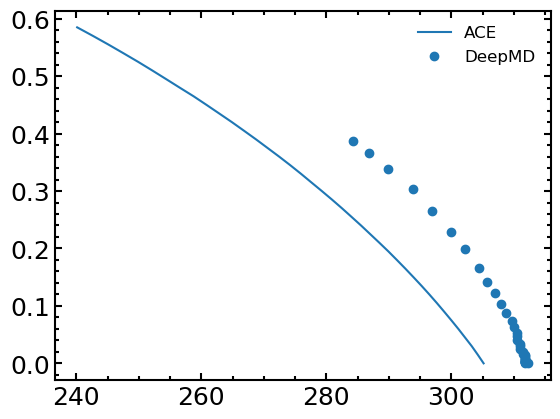

In [48]:
# plt.scatter(exp_liq['T'], exp_liq['P'], c='gray', label='exp')
plt.plot(T_lst, np.array(P_lst)*1e-4, label='ACE')
plt.scatter(ih_scan['T'], ih_scan['P'], label='DeepMD')
# plt.scatter(exp_pd['T'], exp_pd['P']*1e-3, c='gray', label='exp')
# plt.yscale('log')
plt.legend(frameon=0, loc=1, fontsize=12)

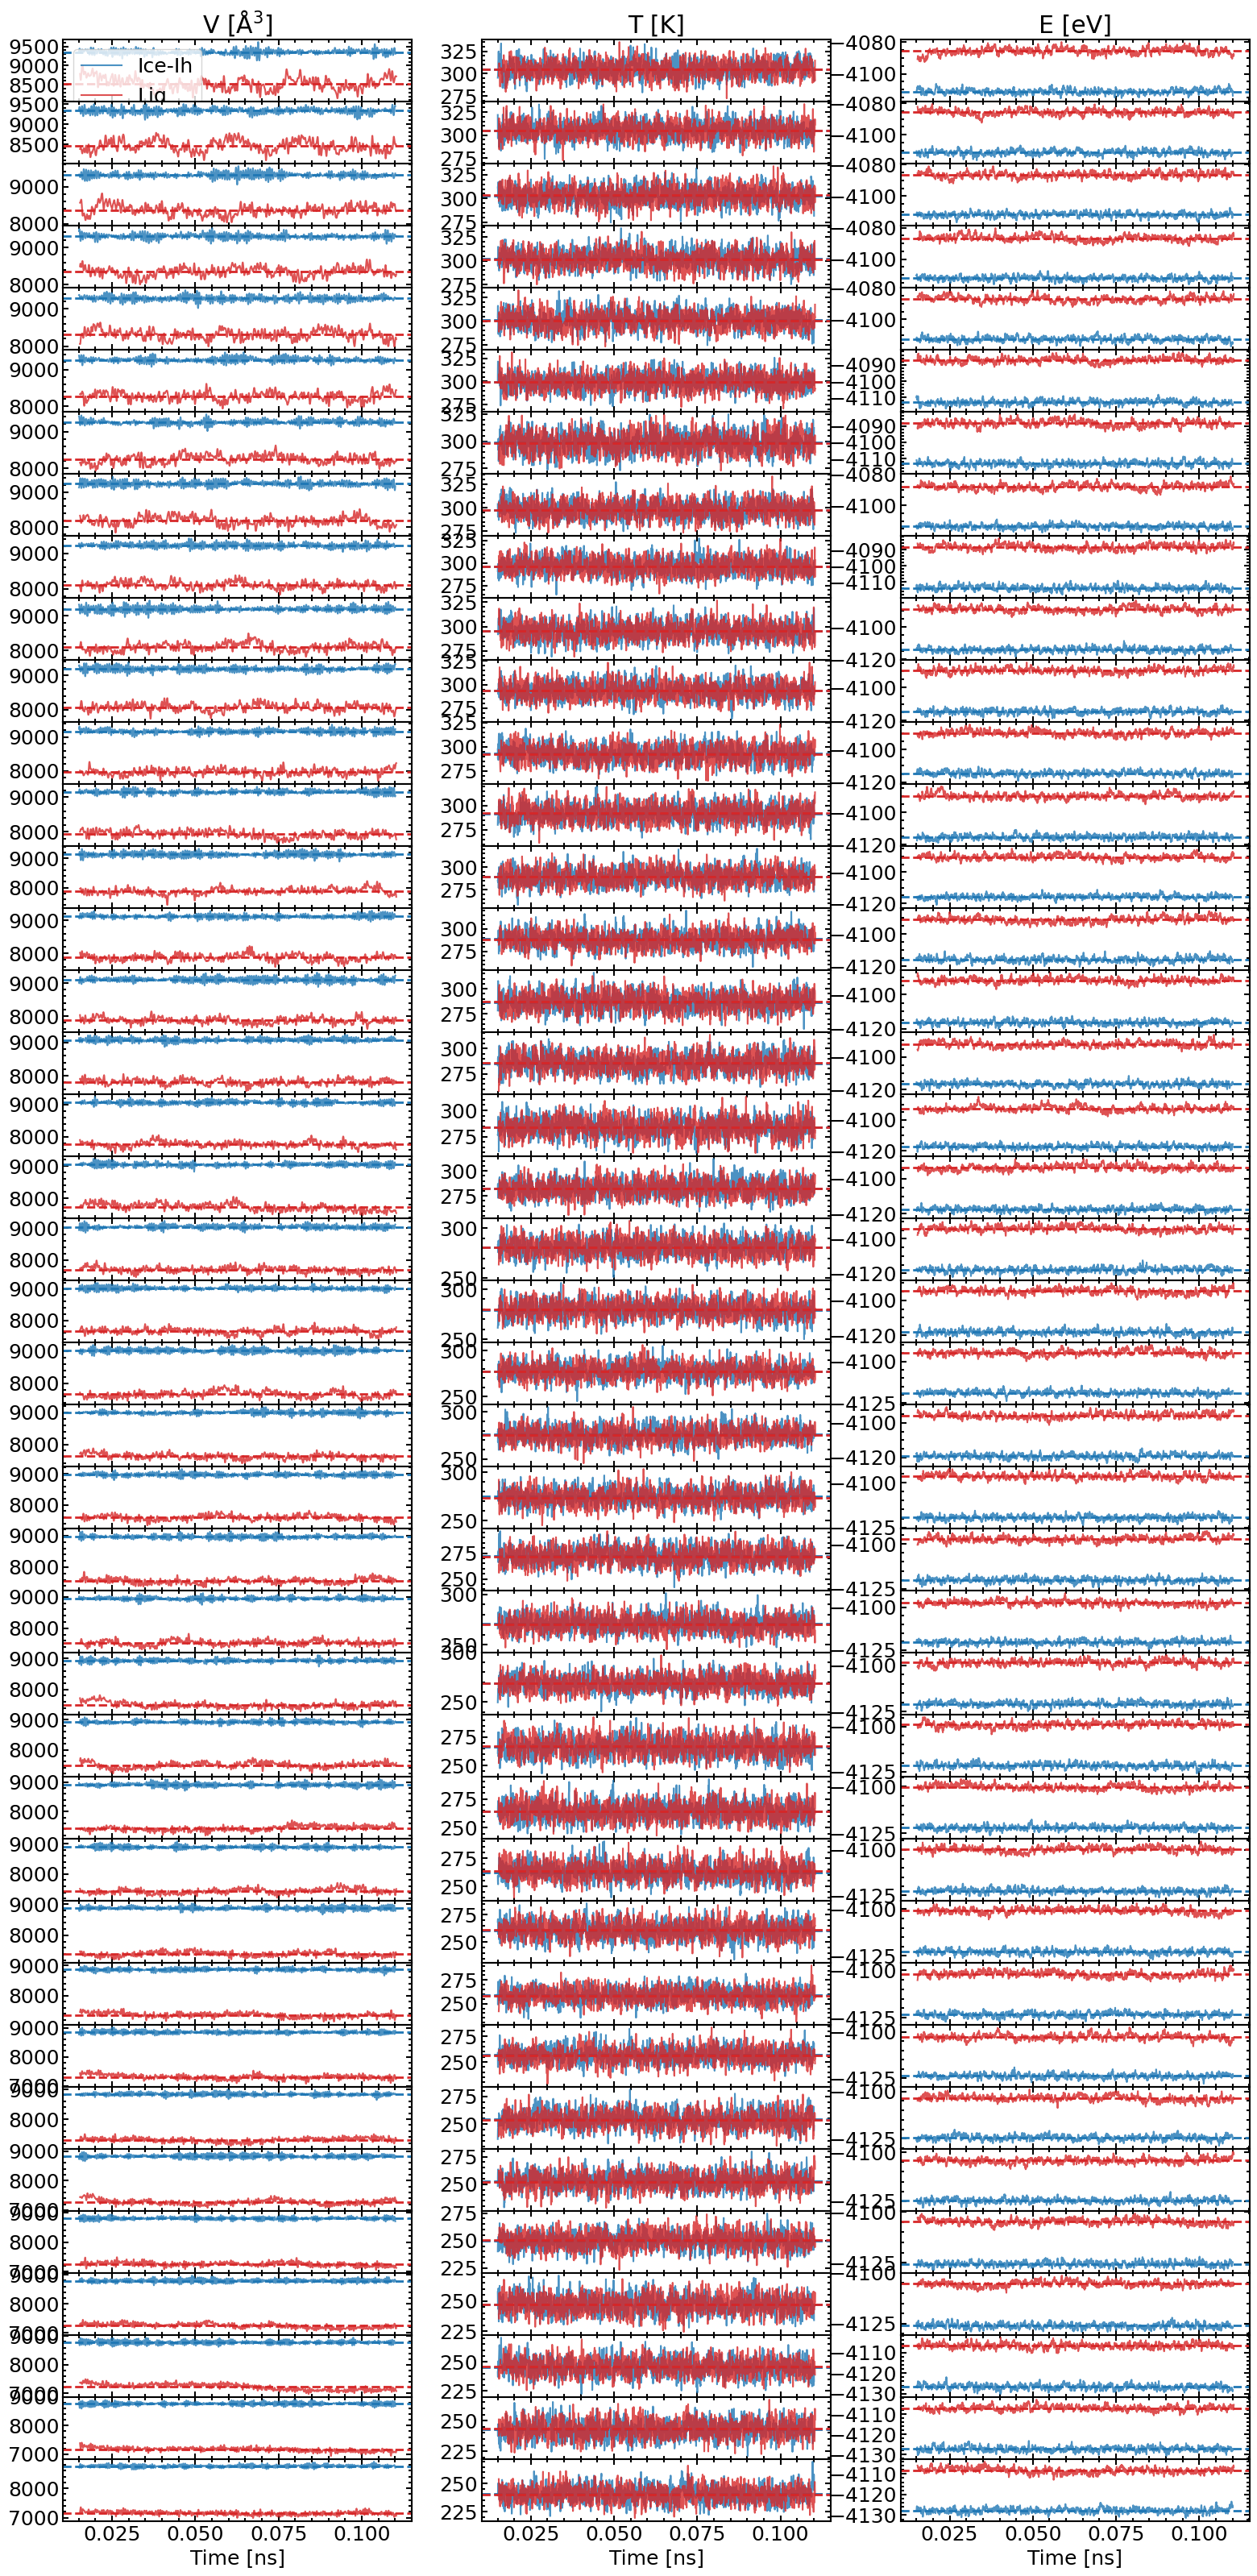

In [35]:
skip = 0
fig, ax = plt.subplots(figsize=(19,40), ncols=3, nrows=n_pnts)
fig.subplots_adjust(hspace=0)
alpha = 0.8
skip=100
for i in range(n_pnts):
    path = f'/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/ice_ih-liq/ice_ih_T_{T_lst[i]}_P_{P_lst[i]}'
    log = read_log(f'{path}')[-1]
        
    
    ax[i,0].plot(log.Step[skip:]*5e-7, log.Volume[skip:], alpha=alpha, c='C0', label='Ice-Ih')
    ax[i,0].axhline(log.Volume[skip:].mean(), ls='--', color='C0', lw=2)
    
    ax[i,1].plot(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=alpha, c='C0')
    ax[i,1].axhline(log.Temp[skip:].mean(), ls='--', color='C0', lw=2)

    ax[i,2].plot(log.Step[skip:]*5e-7,log.TotEng[skip:], alpha=alpha, c='C0')
    ax[i,2].axhline(log.TotEng[skip:].mean(), ls='--', color='C0', lw=2)
    
    path = f'/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/ice_ih-liq/liq_T_{T_lst[i]}_P_{P_lst[i]}'
    log = read_log(f'{path}')[-1]
        
    
    ax[i,0].plot(log.Step[skip:]*5e-7, log.Volume[skip:], alpha=alpha, c='C3', label='Liq')
    ax[i,0].axhline(log.Volume[skip:].mean(), ls='--', color='C3', lw=2)
    
    ax[i,1].plot(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=alpha, c='C3')
    ax[i,1].axhline(log.Temp[skip:].mean(), ls='--', color='C3', lw=2)

    ax[i,2].plot(log.Step[skip:]*5e-7,log.TotEng[skip:], alpha=alpha, c='C3')
    ax[i,2].axhline(log.TotEng[skip:].mean(), ls='--', color='C3', lw=2)


ax[i,0].set_xlabel('Time [ns]')
ax[0,0].set_title('V [$\mathrm{\AA^{3}}$]')

ax[i,1].set_xlabel('Time [ns]')
ax[0,1].set_title('T [K]')

ax[i,2].set_xlabel('Time [ns]')
ax[0,2].set_title('E [eV]')
ax[0,0].legend()

In [27]:
from functools import partial
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [28]:
def delta_P(T, P1, P2):
    return P1(T) - P2(T)

In [41]:
P_1 = ih_liq[1,:]; T_1 = ih_liq[0,:]
P_2 = v_liq[1,:];  T_2 = v_liq[0,:]

T_1_unique, idx_1 = np.unique(T_1, return_index=True)
P_1_unique = P_1[idx_1]

T_2_unique, idx_2 = np.unique(T_2, return_index=True)
P_2_unique = P_2[idx_2]

P_1_interp = interp1d(T_1_unique, P_1_unique, kind='cubic')
P_2_interp = interp1d(T_2_unique, P_2_unique, kind='cubic')

T_guess_min = max(min(T_1_unique), min(T_2_unique))
T_guess_max = min(max(T_1_unique), max(T_2_unique))

delta_func = partial(delta_P, P1=P_1_interp, P2=P_2_interp)
T_triple_ih_liq = brentq(delta_func, T_guess_min, T_guess_max)
P_triple_ih_liq = P_1_interp(T_triple_ih_liq)
T_triple_ih_liq,P_triple_ih_liq

(273.88245162005916, array(0.34786539))

In [42]:
P_1 = v_liq[1,:]; T_1 = v_liq[0,:]
P_2 = vi_liq[1,:];  T_2 = vi_liq[0,:]

T_1_unique, idx_1 = np.unique(T_1, return_index=True)
P_1_unique = P_1[idx_1]

T_2_unique, idx_2 = np.unique(T_2, return_index=True)
P_2_unique = P_2[idx_2]

P_1_interp = interp1d(T_1_unique, P_1_unique, kind='cubic')
P_2_interp = interp1d(T_2_unique, P_2_unique, kind='cubic')

T_guess_min = max(min(T_1_unique), min(T_2_unique))
T_guess_max = min(max(T_1_unique), max(T_2_unique))

delta_func = partial(delta_P, P1=P_1_interp, P2=P_2_interp)
T_triple_v_vi = brentq(delta_func, T_guess_min, T_guess_max)
P_triple_v_vi = P_1_interp(T_triple_v_vi)
T_triple_v_vi,P_triple_v_vi

(288.3233325957617, array(0.58879328))

In [43]:
P_1 = ii_liq[1,:10]; T_1 = ii_liq[0,:10]
P_2 = iii_liq[1,:10];  T_2 = iii_liq[0,:10]

T_1_unique, idx_1 = np.unique(T_1, return_index=True)
P_1_unique = P_1[idx_1]

T_2_unique, idx_2 = np.unique(T_2, return_index=True)
P_2_unique = P_2[idx_2]

P_1_interp = interp1d(T_1_unique, P_1_unique, kind='cubic')
P_2_interp = interp1d(T_2_unique, P_2_unique, kind='cubic')

T_guess_min = max(min(T_1_unique), min(T_2_unique))
T_guess_max = min(max(T_1_unique), max(T_2_unique))

delta_func = partial(delta_P, P1=P_1_interp, P2=P_2_interp)
T_triple_ii_iii = brentq(delta_func, T_guess_min, T_guess_max)
P_triple_ii_iii = P_1_interp(T_triple_ii_iii)
T_triple_ii_iii,P_triple_ii_iii

(265.5730836351148, array(0.27266596))

In [44]:
P_1 = ih_liq[1,:]; T_1 = ih_liq[0,:]
P_2 = ii_liq[1,:]; T_2 = ii_liq[0,:]

T_1_unique, idx_1 = np.unique(T_1, return_index=True)
P_1_unique = P_1[idx_1]

T_2_unique, idx_2 = np.unique(T_2, return_index=True)
P_2_unique = P_2[idx_2]

P_1_interp = interp1d(T_1_unique, P_1_unique, kind='cubic')
P_2_interp = interp1d(T_2_unique, P_2_unique, kind='cubic')

T_guess_min = max(min(T_1_unique), min(T_2_unique))
T_guess_max = min(max(T_1_unique), max(T_2_unique))

delta_func = partial(delta_P, P1=P_1_interp, P2=P_2_interp)
T_triple_ih_ii = brentq(delta_func, T_guess_min, T_guess_max)
P_triple_ih_ii = P_1_interp(T_triple_ih_ii)
T_triple_ih_ii,P_triple_ih_ii

(269.6176544140554, array(0.38289157))

In [45]:
P_1 = ii_ih[1,:]; T_1 = ii_ih[0,:]
P_2 = ih_v[1,:]; T_2 = ih_v[0,:]

T_1_unique, idx_1 = np.unique(T_1, return_index=True)
P_1_unique = P_1[idx_1]

T_2_unique, idx_2 = np.unique(T_2, return_index=True)
P_2_unique = P_2[idx_2]

P_1_interp = interp1d(T_1_unique, P_1_unique, kind='cubic')
P_2_interp = interp1d(T_2_unique, P_2_unique, kind='cubic')

T_guess_min = max(min(T_1_unique), min(T_2_unique))
T_guess_max = min(max(T_1_unique), max(T_2_unique))

delta_func = partial(delta_P, P1=P_1_interp, P2=P_2_interp)
T_triple_ii_v = brentq(delta_func, T_guess_min, T_guess_max)
P_triple_ii_v = P_1_interp(T_triple_ii_v)
T_triple_ii_v,P_triple_ii_v

(215.4689847088993, array(0.39896508))

In [552]:
P_1 = ii_ih[1,:]; T_1 = ii_ih[0,:]
P_2 = ii_v_2nd[1,:]; T_2 = ii_v_2nd[0,:]

T_1_unique, idx_1 = np.unique(T_1, return_index=True)
P_1_unique = P_1[idx_1]

T_2_unique, idx_2 = np.unique(T_2, return_index=True)
P_2_unique = P_2[idx_2]

P_1_interp = interp1d(T_1_unique, P_1_unique, kind='cubic')
P_2_interp = interp1d(T_2_unique, P_2_unique, kind='cubic')

T_guess_min = max(min(T_1_unique), min(T_2_unique))
T_guess_max = min(max(T_1_unique), max(T_2_unique))

delta_func = partial(delta_P, P1=P_1_interp, P2=P_2_interp)
T_triple_ih_ii_v = brentq(delta_func, T_guess_min, T_guess_max)
P_triple_ih_ii_v = P_1_interp(T_triple_ih_ii_v)
T_triple_ih_ii_v,P_triple_ih_ii_v

(215.66051513749954, array(0.39893704))

In [555]:
T_triple_ii_v-T_triple_ih_ii_v,(P_triple_ii_v-P_triple_ih_ii_v)*1e4

(-0.19153042860023106, 0.28044818766337354)

In [559]:
np.std([T_triple_ii_v,T_triple_ih_ii_v]), np.std([P_triple_ii_v,P_triple_ih_ii_v])

(0.09576521430011553, 1.4022409383168677e-05)

In [47]:
P_1 = ii_liq[1,:]; T_1 = ii_liq[0,:]
P_2 = v_liq[1,:]; T_2 = v_liq[0,:]

T_1_unique, idx_1 = np.unique(T_1, return_index=True)
P_1_unique = P_1[idx_1]

T_2_unique, idx_2 = np.unique(T_2, return_index=True)
P_2_unique = P_2[idx_2]

P_1_interp = interp1d(T_1_unique, P_1_unique, kind='cubic')
P_2_interp = interp1d(T_2_unique, P_2_unique, kind='cubic')

T_guess_min = max(min(T_1_unique), min(T_2_unique))
T_guess_max = min(max(T_1_unique), max(T_2_unique))

delta_func = partial(delta_P, P1=P_1_interp, P2=P_2_interp)
T_triple_ii_v_2 = brentq(delta_func, T_guess_min, T_guess_max)
P_triple_ii_v_2 = P_1_interp(T_triple_ii_v_2)
T_triple_ii_v_2,P_triple_ii_v_2*1e4

(263.1503274251632, 2223.147977117857)

In [ ]:
P_1 = ii_liq[1,:]; T_1 = ii_liq[0,:]
P_2 = v_liq[1,:]; T_2 = v_liq[0,:]

T_1_unique, idx_1 = np.unique(T_1, return_index=True)
P_1_unique = P_1[idx_1]

T_2_unique, idx_2 = np.unique(T_2, return_index=True)
P_2_unique = P_2[idx_2]

P_1_interp = interp1d(T_1_unique, P_1_unique, kind='cubic')
P_2_interp = interp1d(T_2_unique, P_2_unique, kind='cubic')

T_guess_min = max(min(T_1_unique), min(T_2_unique))
T_guess_max = min(max(T_1_unique), max(T_2_unique))

delta_func = partial(delta_P, P1=P_1_interp, P2=P_2_interp)
T_triple_ii_v_2 = brentq(delta_func, T_guess_min, T_guess_max)
P_triple_ii_v_2 = P_1_interp(T_triple_ii_v_2)
T_triple_ii_v_2,P_triple_ii_v_2*1e4

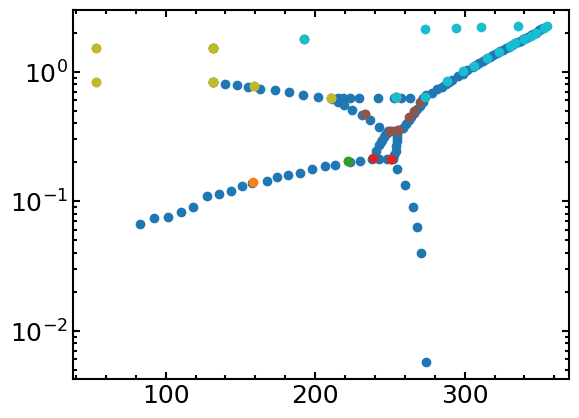

In [466]:
iceI=pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/salzman/IceI.txt',delimiter='\t',header=None).to_numpy()[:,::-1]    
iceIII=pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/salzman/IceIII.txt',delimiter='\t',header=None).to_numpy()[:,::-1]
iceV=pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/salzman/IceV.txt',delimiter='\t',header=None,na_values='--').to_numpy()[:,::-1]
iceVI=pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/salzman/IceVI.txt',delimiter='\t',header=None).to_numpy()[:,::-1]
iceVII=pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/salzman/Ice VII and VIII.txt',delimiter='\t',header=None).to_numpy()[:,::-1]

iceI[:,::2]+=273.15
iceIII[:,::2]+=273.15
iceV[:,::2]+=273.15
iceVI[:,::2]+=273.15
iceI[:,1::2]*=1.01325
iceIII[:,1::2]*=1.01325
iceV[:,1::2]*=1.01325
iceVI[:,1::2]*=1.01325
plt.scatter(exp_pd['P'], exp_pd['T']*1e-4*1.01325)

plt.scatter(iceI[:,2],iceI[:,3])
plt.scatter(iceI[:,4],iceI[:,5])
plt.scatter(iceIII[:,0],iceIII[:,1])
plt.scatter(iceV[:,0],iceV[:,1])
plt.scatter(iceV[:,2],iceV[:,3])
keepT=iceVI[:,2]>0
keepP=iceVI[:,3]<1000000*1.01325
keep=keepT*keepP
plt.scatter(iceVI[keep,2],iceVI[keep,3])
plt.scatter(iceVI[:,0],iceVI[:,1])
plt.scatter(iceVI[:,2],iceVI[:,3])
plt.scatter(iceVI[:,4],iceVI[:,5])

plt.yscale('log')

In [908]:
# exp_pd = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/Salzmann.dat',names=['T','P'], sep='\s+')
exp_pd = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/ref_data/data_exp.csv',names=['T','P'], sep=',', dtype=float)


pd_scan_liq_ih = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/PD_Zhang/Liq_Ih.dat',names=['T','P'], sep='\s+')
pd_scan_liq_v = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/PD_Zhang/Liq_V.dat',names=['T','P'], sep='\s+')
pd_scan_liq_vi = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/PD_Zhang/Liq_VI.dat',names=['T','P'], sep='\s+')
pd_scan_ih_ii = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/PD_Zhang/Ih_II.dat',names=['T','P'], sep='\s+')
pd_scan_ih_v = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/PD_Zhang/Ih_V.dat',names=['T','P'], sep='\s+')
pd_scan_ii_v = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/PD_Zhang/II_V.dat',names=['T','P'], sep='\s+')
pd_scan_ii_vi = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/PD_Zhang/II_VI.dat',names=['T','P'], sep='\s+')
pd_scan_v_vi = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/PD_Zhang/V_VI.dat',names=['T','P'], sep='\s+')
pd_scan_vi_vii = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/PD_Zhang/VI_VII.dat',names=['T','P'], sep=',')


pd_mp_bol_ih_liq = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ih_liq.dat',names=['T','P'], sep=',')
pd_mp_bol_iii_liq = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/iii_liq.dat',names=['T','P'], sep=',')
pd_mp_bol_v_liq = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/v_liq.dat',names=['T','P'], sep=',')
pd_mp_bol_ih_ii = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ih_ii.dat',names=['T','P'], sep=',')
pd_mp_bol_ii_iii = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ii_iii.dat',names=['T','P'], sep=',')
pd_mp_bol_ii_v = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ii_v.dat',names=['T','P'], sep=',')
pd_mp_bol_v_vi = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/v_vi.dat',names=['T','P'], sep=',')


ih_liq = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/ih_liq.dat')
ii_liq = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/ii_liq.dat')
iii_liq = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/iii_liq.dat')
v_liq = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/v_liq.dat')
vi_liq = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/vi_liq.dat')
vii_liq = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/vii_liq.dat')
v_vi = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/v_vi.dat')
ih_v = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/ih_v.dat')
ii_ih = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/ii_ih.dat')
iii_ih = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/iii_ih.dat')
ii_v = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/ii_v.dat')
ii_v_2nd = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/ii_v_2nd.dat')
ii_vi = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/ii_vi.dat')
vi_vii = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/vi_vii.dat')

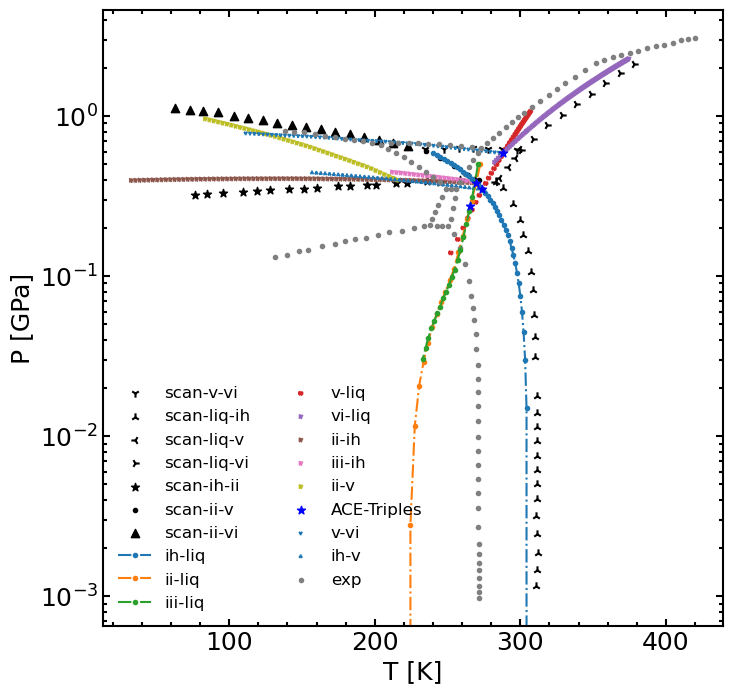

In [495]:
plt.figure(figsize=(8,8))

plt.scatter(pd_scan_v_vi['T'], pd_scan_v_vi['P'], c='k', label='scan-v-vi', marker='1', ls='-')
plt.scatter(pd_scan_liq_ih['T'], pd_scan_liq_ih['P'], c='k', label='scan-liq-ih', marker='2', ls='-')
plt.scatter(pd_scan_liq_v['T'], pd_scan_liq_v['P'], c='k', label='scan-liq-v', marker='3', ls='-')
plt.scatter(pd_scan_liq_vi['T'], pd_scan_liq_vi['P'], c='k', label='scan-liq-vi', marker='4', ls='-')
plt.scatter(pd_scan_ih_ii['T'], pd_scan_ih_ii['P'], c='k', label='scan-ih-ii', marker='*', ls='-')
plt.scatter(pd_scan_ii_v['T'], pd_scan_ii_v['P'], c='k', label='scan-ii-v', marker='.', ls='-')
plt.scatter(pd_scan_ii_vi['T'], pd_scan_ii_vi['P'], c='k', label='scan-ii-vi', marker='^', ls='-')

plt.plot(ih_liq[0,:],ih_liq[1,:], label='ih-liq', marker='.', ls='-.', c='C0')
plt.plot(ii_liq[0,:],ii_liq[1,:], label='ii-liq', marker='.', ls='-.', c='C1')
plt.plot(iii_liq[0,:],iii_liq[1,:], label='iii-liq', marker='.', ls='-.', c='C2')
plt.scatter(v_liq[0,:],v_liq[1,:], label='v-liq', marker='.', ls='--', c='C3')
plt.scatter(vi_liq[0,:],vi_liq[1,:], label='vi-liq', marker='.', ls=':', c='C4')
plt.scatter(ii_ih[0,:],ii_ih[1,:], label='ii-ih', marker='.', ls=':', c='C5')
plt.scatter(iii_ih[0,:],iii_ih[1,:], label='iii-ih', marker='.', ls=':', c='C6')
plt.scatter(ii_v[0,:],ii_v[1,:], label='ii-v', marker='.', ls=':', c='C8')

plt.scatter(T_triple_ih_liq, P_triple_ih_liq, marker='*', color='b', zorder=4)
plt.scatter(T_triple_v_vi, P_triple_v_vi, marker='*', color='b', zorder=4)
plt.scatter(T_triple_ih_ii, P_triple_ih_ii, marker='*', color='b', zorder=4)
# plt.scatter(T_triple_ih_iii, P_triple_ih_iii, marker='*', color='b', zorder=4)
plt.scatter(T_triple_ii_iii, P_triple_ii_iii, marker='*', color='b', label='ACE-Triples', zorder=4)

plt.scatter(v_vi[0,:],v_vi[1,:], label='v-vi', marker='1', ls=':', c='C0')
plt.scatter(ih_v[0,:],ih_v[1,:], label='ih-v', marker='2', ls=':', c='C0')

plt.scatter(exp_pd['T'], exp_pd['P'], c='gray', label='exp', marker='.')

plt.xlabel('T [K]')
plt.ylabel('P [GPa]')

plt.yscale('log')

plt.legend(frameon=0, loc='best', fontsize=12, ncol=2)

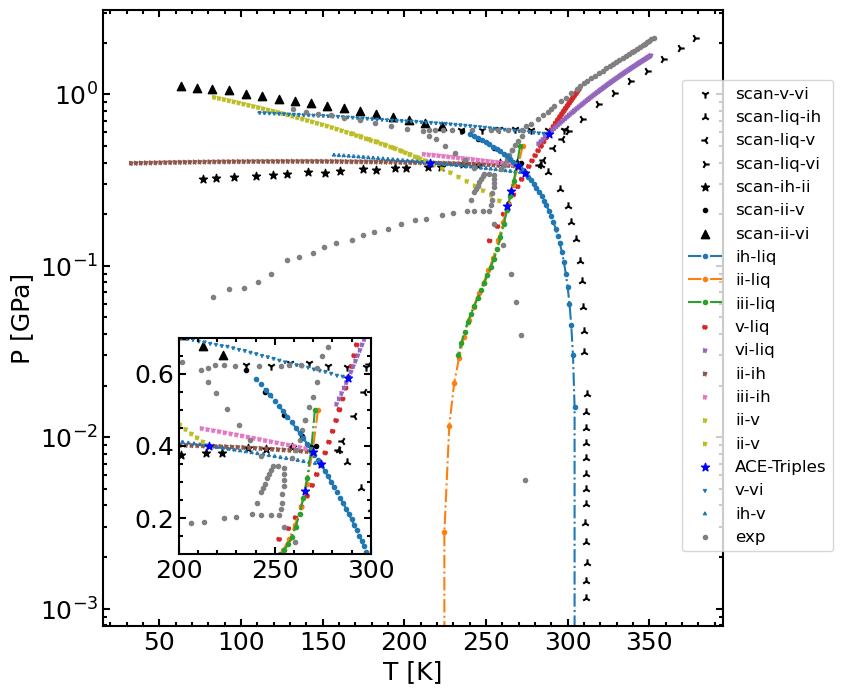

In [50]:
fig, ax= plt.subplots(figsize=(8,8))

plt.scatter(pd_scan_v_vi['T'], pd_scan_v_vi['P'], c='k', label='scan-v-vi', marker='1', ls='-')
plt.scatter(pd_scan_liq_ih['T'], pd_scan_liq_ih['P'], c='k', label='scan-liq-ih', marker='2', ls='-')
plt.scatter(pd_scan_liq_v['T'], pd_scan_liq_v['P'], c='k', label='scan-liq-v', marker='3', ls='-')
plt.scatter(pd_scan_liq_vi['T'], pd_scan_liq_vi['P'], c='k', label='scan-liq-vi', marker='4', ls='-')
plt.scatter(pd_scan_ih_ii['T'], pd_scan_ih_ii['P'], c='k', label='scan-ih-ii', marker='*', ls='-')
plt.scatter(pd_scan_ii_v['T'], pd_scan_ii_v['P'], c='k', label='scan-ii-v', marker='.', ls='-')
plt.scatter(pd_scan_ii_vi['T'], pd_scan_ii_vi['P'], c='k', label='scan-ii-vi', marker='^', ls='-')

plt.plot(ih_liq[0,:],ih_liq[1,:], label='ih-liq', marker='.', ls='-.', c='C0')
plt.plot(ii_liq[0,:],ii_liq[1,:], label='ii-liq', marker='.', ls='-.', c='C1')
plt.plot(iii_liq[0,:],iii_liq[1,:], label='iii-liq', marker='.', ls='-.', c='C2')
plt.scatter(v_liq[0,:],v_liq[1,:], label='v-liq', marker='.', ls='--', c='C3')
plt.scatter(vi_liq[0,:],vi_liq[1,:], label='vi-liq', marker='.', ls=':', c='C4')
plt.scatter(ii_ih[0,:],ii_ih[1,:], label='ii-ih', marker='.', ls=':', c='C5')
plt.scatter(iii_ih[0,:],iii_ih[1,:], label='iii-ih', marker='.', ls=':', c='C6')
plt.scatter(ii_v[0,:],ii_v[1,:], label='ii-v', marker='.', ls=':', c='C8')
plt.scatter(ii_v_2nd[0,:],ii_v_2nd[1,:], label='ii-v', marker='.', ls=':', c='C8')


plt.scatter(T_triple_ih_liq, P_triple_ih_liq, marker='*', color='b', zorder=4)
plt.scatter(T_triple_v_vi, P_triple_v_vi, marker='*', color='b', zorder=4)
plt.scatter(T_triple_ih_ii, P_triple_ih_ii, marker='*', color='b', zorder=4)
# plt.scatter(T_triple_ih_iii, P_triple_ih_iii, marker='*', color='b', zorder=4)
plt.scatter(T_triple_ii_iii, P_triple_ii_iii, marker='*', color='b', zorder=4)
plt.scatter(T_triple_ii_v, P_triple_ii_v, marker='*', color='b', zorder=4)
plt.scatter(T_triple_ii_v_2, P_triple_ii_v_2, marker='*', color='b', zorder=4, label='ACE-Triples')

plt.scatter(v_vi[0,:],v_vi[1,:], label='v-vi', marker='1', ls=':', c='C0')
plt.scatter(ih_v[0,:],ih_v[1,:], label='ih-v', marker='2', ls=':', c='C0')

plt.scatter(exp_pd['P'], exp_pd['T']*1e-4, c='gray', label='exp', marker='.')

plt.xlabel('T [K]')
plt.ylabel('P [GPa]')

plt.yscale('log')

# Create an inset axis
ax_inset = plt.axes([0.22, 0.2, 0.24, 0.27])
ax_inset.set_xscale('linear')
ax_inset.set_yscale('linear')
ax_inset.set_xlim(200, 300)
ax_inset.set_ylim(0.1, 0.7)

# Plot the data in the inset axis
ax_inset.scatter(pd_scan_v_vi['T'], pd_scan_v_vi['P'], c='k', label='scan-v-vi', marker='1', ls='-')
ax_inset.scatter(pd_scan_liq_ih['T'], pd_scan_liq_ih['P'], c='k', label='scan-liq-ih', marker='2', ls='-')
ax_inset.scatter(pd_scan_liq_v['T'], pd_scan_liq_v['P'], c='k', label='scan-liq-v', marker='3', ls='-')
ax_inset.scatter(pd_scan_liq_vi['T'], pd_scan_liq_vi['P'], c='k', label='scan-liq-vi', marker='4', ls='-')
ax_inset.scatter(pd_scan_ih_ii['T'], pd_scan_ih_ii['P'], c='k', label='scan-ih-ii', marker='*', ls='-')
ax_inset.scatter(pd_scan_ii_v['T'], pd_scan_ii_v['P'], c='k', label='scan-ii-v', marker='.', ls='-')
ax_inset.scatter(pd_scan_ii_vi['T'], pd_scan_ii_vi['P'], c='k', label='scan-ii-vi', marker='^', ls='-')

ax_inset.plot(ih_liq[0,:],ih_liq[1,:], label='ih-liq', marker='.', ls='-.', c='C0')
ax_inset.plot(ii_liq[0,:],ii_liq[1,:], label='ii-liq', marker='.', ls='-.', c='C1')
ax_inset.plot(iii_liq[0,:],iii_liq[1,:], label='iii-liq', marker='.', ls='-.', c='C2')
ax_inset.scatter(v_liq[0,:],v_liq[1,:], label='v-liq', marker='.', ls='--', c='C3')
ax_inset.scatter(vi_liq[0,:],vi_liq[1,:], label='vi-liq', marker='.', ls=':', c='C4')
ax_inset.scatter(ii_ih[0,:],ii_ih[1,:], label='ii-ih', marker='.', ls=':', c='C5')
ax_inset.scatter(iii_ih[0,:],iii_ih[1,:], label='iii-ih', marker='.', ls=':', c='C6')
ax_inset.scatter(ii_v[0,:],ii_v[1,:], label='ii-v', marker='.', ls=':', c='C8')

ax_inset.scatter(T_triple_ih_liq, P_triple_ih_liq, marker='*', color='b', zorder=4)
ax_inset.scatter(T_triple_v_vi, P_triple_v_vi, marker='*', color='b', zorder=4)
ax_inset.scatter(T_triple_ih_ii, P_triple_ih_ii, marker='*', color='b', zorder=4)
# ax_inset.scatter(T_triple_ih_iii, P_triple_ih_iii, marker='*', color='b', zorder=4)
ax_inset.scatter(T_triple_ii_iii, P_triple_ii_iii, marker='*', color='b', zorder=4)
ax_inset.scatter(T_triple_ii_v, P_triple_ii_v, marker='*', color='b', label='ACE-Triples', zorder=4)

ax_inset.scatter(v_vi[0,:],v_vi[1,:], label='v-vi', marker='1', ls=':', c='C0')
ax_inset.scatter(ih_v[0,:],ih_v[1,:], label='ih-v', marker='2', ls=':', c='C0')

ax_inset.scatter(exp_pd['P'], exp_pd['T']*1e-4, c='gray', label='exp', marker='.')

# ax.indicate_inset_zoom(ax_inset, edgecolor="black")

ax.legend(frameon=1, loc='best', fontsize=12, ncol=1, bbox_to_anchor=(.92,.9))
plt.show()

In [51]:
P_1 = ii_v[1,:]; T_1 = ii_v[0,:]
P_2 = v_vi[1,:]; T_2 = v_vi[0,:]

T_1_unique, idx_1 = np.unique(T_1, return_index=True)
P_1_unique = P_1[idx_1]

T_2_unique, idx_2 = np.unique(T_2, return_index=True)
P_2_unique = P_2[idx_2]

P_1_interp = interp1d(T_1_unique, P_1_unique, kind='cubic')
P_2_interp = interp1d(T_2_unique, P_2_unique, kind='cubic')

T_guess_min = max(min(T_1_unique), min(T_2_unique))
T_guess_max = min(max(T_1_unique), max(T_2_unique))

delta_func = partial(delta_P, P1=P_1_interp, P2=P_2_interp)
T_triple_ii_vi = brentq(delta_func, T_guess_min, T_guess_max)
P_triple_ii_vi = P_1_interp(T_triple_ii_vi)
T_triple_ii_vi,P_triple_ii_vi*1e4

(126.32496822274895, 7690.6861446049525)

In [564]:
P_1 = vi_liq[1,:]; T_1 = vi_liq[0,:]
P_2 = vii_liq[1,:]; T_2 = vii_liq[0,:]

T_1_unique, idx_1 = np.unique(T_1, return_index=True)
P_1_unique = P_1[idx_1]

T_2_unique, idx_2 = np.unique(T_2, return_index=True)
P_2_unique = P_2[idx_2]

P_1_interp = interp1d(T_1_unique, P_1_unique, kind='cubic')
P_2_interp = interp1d(T_2_unique, P_2_unique, kind='cubic')

T_guess_min = max(min(T_1_unique), min(T_2_unique))
T_guess_max = min(max(T_1_unique), max(T_2_unique))

delta_func = partial(delta_P, P1=P_1_interp, P2=P_2_interp)
T_triple_vi_vii = brentq(delta_func, T_guess_min, T_guess_max)
P_triple_vi_vii = P_1_interp(T_triple_vi_vii)
T_triple_vi_vii,P_triple_vi_vii*1e4

(330.40961326777926, 12509.012794530714)

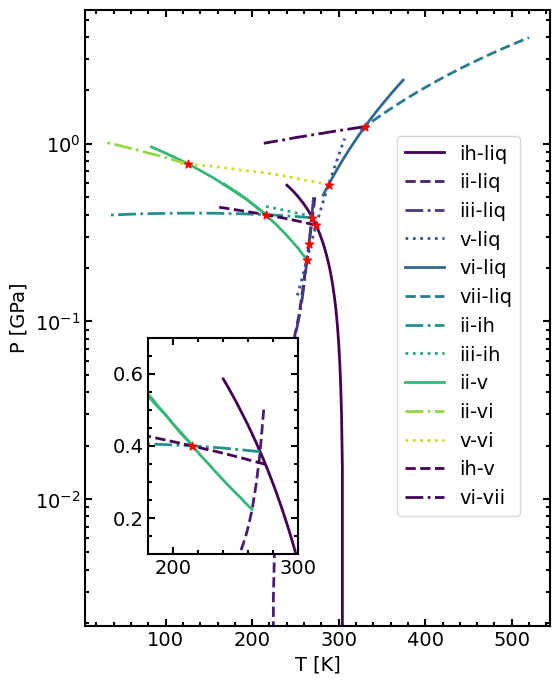

In [765]:
mpl.rcParams['font.size'] = 14
fig, ax= plt.subplots(figsize=(6,8))

solid_cmap = mpl.cm.viridis

plt.plot(ih_liq[0,:],ih_liq[1,:], label='ih-liq', marker='', ls='-', c=solid_cmap(0), lw=2)
plt.plot(ii_liq[0,:],ii_liq[1,:], label='ii-liq', marker='', ls='--', c=solid_cmap(1/12), lw=2)
plt.plot(iii_liq[0,:],iii_liq[1,:], label='iii-liq', marker='', ls='-.', c=solid_cmap(2/12), lw=2)
plt.plot(v_liq[0,:],v_liq[1,:], label='v-liq', marker='', ls=':', c=solid_cmap(3/12), lw=2)
plt.plot(vi_liq[0,:],vi_liq[1,:], label='vi-liq', marker='', ls='-', c=solid_cmap(4/12), lw=2)
plt.plot(vii_liq[0,:],vii_liq[1,:], label='vii-liq', marker='', ls='--', c=solid_cmap(5/12), lw=2)
plt.plot(ii_ih[0,:],ii_ih[1,:], label='ii-ih', marker='', ls='-.', c=solid_cmap(6/12), lw=2)
plt.plot(iii_ih[0,:],iii_ih[1,:], label='iii-ih', marker='', ls=':', c=solid_cmap(7/12), lw=2)
plt.plot(ii_v[0,:],ii_v[1,:], label='ii-v', marker='', ls='-', c=solid_cmap(8/12), lw=2)
plt.plot(ii_v_2nd[0,:],ii_v_2nd[1,:], marker='', ls='-', c=solid_cmap(8/12), lw=2)
plt.plot(ii_vi[0,:],ii_vi[1,:], label='ii-vi', marker='', ls='-.', c=solid_cmap(10/12), lw=2)
plt.plot(v_vi[0,:],v_vi[1,:], label='v-vi', marker='', ls=':', c=solid_cmap(11/12), lw=2)
plt.plot(ih_v[0,:],ih_v[1,:], label='ih-v', marker='', ls='--', c=solid_cmap(1), lw=2)
plt.plot(vi_vii[0,:],vi_vii[1,:], label='vi-vii', marker='', ls='-.', c=solid_cmap(1), lw=2)


plt.scatter(T_triple_ih_liq, P_triple_ih_liq, marker='*', color='r', zorder=4)
plt.scatter(T_triple_v_vi, P_triple_v_vi, marker='*', color='r', zorder=4)
plt.scatter(T_triple_ih_ii, P_triple_ih_ii, marker='*', color='r', zorder=4)
# plt.scatter(T_triple_ih_iii, P_triple_ih_iii, marker='*', color='b', zorder=4)
plt.scatter(T_triple_ii_iii, P_triple_ii_iii, marker='*', color='r', zorder=4)
plt.scatter(T_triple_ii_v, P_triple_ii_v, marker='*', color='r', zorder=4)
plt.scatter(T_triple_ii_v_2, P_triple_ii_v_2, marker='*', color='r', zorder=4)
plt.scatter(T_triple_ii_vi, P_triple_ii_vi, marker='*', color='r', zorder=4)
plt.scatter(T_triple_vi_vii, P_triple_vi_vii, marker='*', color='r', zorder=4)



plt.xlabel('T [K]')
plt.ylabel('P [GPa]')

plt.yscale('log')

# Create an inset axis
ax_inset = plt.axes([0.23, 0.2, 0.25, 0.27])
ax_inset.set_xscale('linear')
ax_inset.set_yscale('linear')
ax_inset.set_xlim(180, 300)
ax_inset.set_ylim(0.1, 0.7)

# Plot the data in the inset axis

ax_inset.plot(ih_liq[0,:],ih_liq[1,:], label='ih-liq', marker='', ls='-', c=solid_cmap(0), lw=2)
ax_inset.plot(ii_liq[0,:],ii_liq[1,:], label='ii-liq', marker='', ls='--', c=solid_cmap(1/12), lw=2)
# ax_inset.plot(iii_liq[0,:],iii_liq[1,:], label='iii-liq', marker='', ls='-.', c=solid_cmap(2/12), lw=2)
# ax_inset.plot(v_liq[0,:],v_liq[1,:], label='v-liq', marker='', ls=':', c=solid_cmap(3/12), lw=2)
# ax_inset.plot(vi_liq[0,:],vi_liq[1,:], label='vi-liq', marker='', ls='-', c=solid_cmap(4/12), lw=2)
# ax_inset.plot(vii_liq[0,:],vii_liq[1,:], label='vii-liq', marker='', ls='--', c=solid_cmap(5/12), lw=2)
ax_inset.plot(ii_ih[0,:],ii_ih[1,:], label='ii-ih', marker='', ls='-.', c=solid_cmap(6/12), lw=2)
# ax_inset.plot(iii_ih[0,:],iii_ih[1,:], label='iii-ih', marker='', ls=':', c=solid_cmap(7/12), lw=2)
ax_inset.plot(ii_v[0,:],ii_v[1,:], label='ii-v', marker='', ls='-', c=solid_cmap(8/12), lw=2)
ax_inset.plot(ii_v_2nd[0,:],ii_v_2nd[1,:], marker='', ls='-', c=solid_cmap(8/12), lw=2)
ax_inset.plot(ii_vi[0,:],ii_vi[1,:], label='ii-vi', marker='', ls='-.', c=solid_cmap(10/12), lw=2)
# ax_inset.plot(v_vi[0,:],v_vi[1,:], label='v-vi', marker='', ls=':', c=solid_cmap(11/12), lw=2)
ax_inset.plot(ih_v[0,:],ih_v[1,:], label='ih-v', marker='', ls='--', c=solid_cmap(1), lw=2)

# ax_inset.scatter(T_triple_ih_liq, P_triple_ih_liq, marker='*', color='r', zorder=4)
# ax_inset.scatter(T_triple_v_vi, P_triple_v_vi, marker='*', color='r', zorder=4)
# ax_inset.scatter(T_triple_ih_ii, P_triple_ih_ii, marker='*', color='r', zorder=4)
# ax_inset.scatter(T_triple_ih_iii, P_triple_ih_iii, marker='*', color='b', zorder=4)
# ax_inset.scatter(T_triple_ii_iii, P_triple_ii_iii, marker='*', color='r', zorder=4)
ax_inset.scatter(T_triple_ii_v, P_triple_ii_v, marker='*', color='r', label='Triples-points', zorder=4)


# ax.indicate_inset_zoom(ax_inset, edgecolor="black")

ax.legend(frameon=1, loc='best', fontsize=14, ncol=1, bbox_to_anchor=(.65,.81))
plt.show()
# fig.savefig('../figures/gibbs_duhem.png', bbox_inches = 'tight', dpi=300);
mpl.rcParams['font.size'] = 18

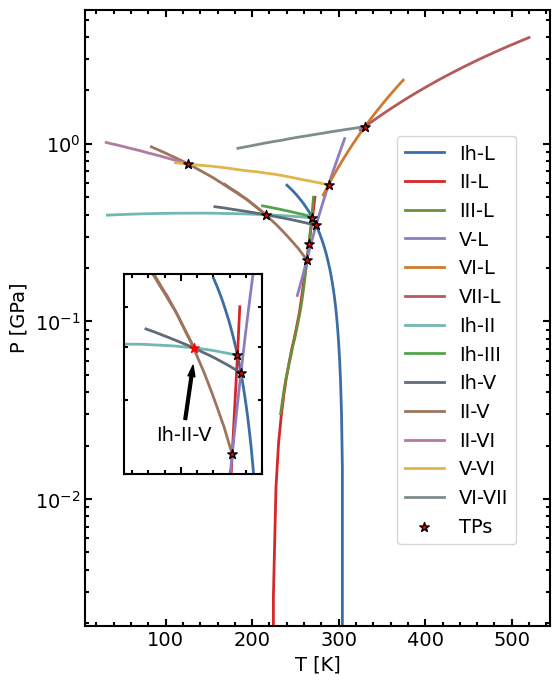

In [947]:
mpl.rcParams['font.size'] = 14
fig, ax= plt.subplots(figsize=(6,8))

gd_colors = [
    "#3A6EA5",  # muted blue
    "C3",  # teal
    "#6C8E3C",  # olive green
    "#8E7DBE",  # soft purple
    "#D07A30",  # muted orange
    "#B55A5A",  # muted brick red
    "#72B7B2",  # seafoam
    "#54A24B",  # green
    "#9D755D",  # warm taupe
    "#B279A2",  # mauve
    "#E0B64B",  # mellow yellow
    "#5F6B7A",  # slate
    "#7F8C8D",  # cool gray
]
tp_color = "#111827"   # near-black (very readable)
tp_color = "r"   # near-black (very readable)
ec = 'k'

s=50
plt.plot(ih_liq[0,:],ih_liq[1,:], label='Ih-L', marker='', ls='-', c=gd_colors[0], lw=2)
plt.plot(ii_liq[0,:],ii_liq[1,:], label='II-L', marker='', ls='-', c=gd_colors[1], lw=2)
plt.plot(iii_liq[0,:],iii_liq[1,:], label='III-L', marker='', ls='-', c=gd_colors[2], lw=2)
plt.plot(v_liq[0,:],v_liq[1,:], label='V-L', marker='', ls='-', c=gd_colors[3], lw=2)
plt.plot(vi_liq[0,:],vi_liq[1,:], label='VI-L', marker='', ls='-', c=gd_colors[4], lw=2)
plt.plot(vii_liq[0,:],vii_liq[1,:], label='VII-L', marker='', ls='-', c=gd_colors[5], lw=2)
plt.plot(ii_ih[0,:],ii_ih[1,:], label='Ih-II', marker='', ls='-', c=gd_colors[6], lw=2)
plt.plot(iii_ih[0,:],iii_ih[1,:], label='Ih-III', marker='', ls='-', c=gd_colors[7], lw=2)
plt.plot(ih_v[0,:],ih_v[1,:], label='Ih-V', marker='', ls='-', c=gd_colors[11], lw=2)
plt.plot(ii_v[0,:],ii_v[1,:], label='II-V', marker='', ls='-', c=gd_colors[8], lw=2)
plt.plot(ii_v_2nd[0,:],ii_v_2nd[1,:], marker='', ls='-', c=gd_colors[8], lw=2)
plt.plot(ii_vi[0,:],ii_vi[1,:], label='II-VI', marker='', ls='-', c=gd_colors[9], lw=2)
plt.plot(v_vi[0,:],v_vi[1,:], label='V-VI', marker='', ls='-', c=gd_colors[10], lw=2)
plt.plot(vi_vii[0,:],vi_vii[1,:], label='VI-VII', marker='', ls='-', c=gd_colors[12], lw=2)


plt.scatter(T_triple_ih_liq, P_triple_ih_liq, marker='*', color=tp_color, zorder=4,s=50, ec=ec)
plt.scatter(T_triple_v_vi, P_triple_v_vi, marker='*', color=tp_color, zorder=4,s=50, ec=ec)
plt.scatter(T_triple_ih_ii, P_triple_ih_ii, marker='*', color=tp_color, zorder=4,s=50, ec=ec)
# plt.scatter(T_triple_ih_iii, P_triple_ih_iii, marker='*', color='b', zorder=4)
plt.scatter(T_triple_ii_iii, P_triple_ii_iii, marker='*', color=tp_color, zorder=4,s=50, ec=ec)
plt.scatter(T_triple_ii_v, P_triple_ii_v, marker='*', color=tp_color, zorder=4,s=50, ec=ec)
plt.scatter(T_triple_ii_v_2, P_triple_ii_v_2, marker='*', color=tp_color, zorder=4,s=50, ec=ec)
plt.scatter(T_triple_ii_vi, P_triple_ii_vi, marker='*', color=tp_color, zorder=4,s=50, ec=ec)
plt.scatter(T_triple_vi_vii, P_triple_vi_vii, marker='*', color=tp_color, zorder=4, label='TPs',s=50, ec=ec)



plt.xlabel('T [K]')
plt.ylabel('P [GPa]')

plt.yscale('log')

# Create an inset axis
ax_inset = plt.axes([0.19, 0.3, 0.23, 0.25])
ax_inset.set_xscale('linear')
ax_inset.set_yscale('log')
ax_inset.set_xlim(130, 300)
ax_inset.set_ylim(0.2, 0.6)

ax_inset.tick_params(
    axis='both',
    which='both',
    labelbottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False
)

# Plot the data in the inset axis
ax_inset.plot(ih_liq[0,:],ih_liq[1,:], label='ih-liq', marker='', ls='-', c=gd_colors[0], lw=2)
ax_inset.plot(ii_liq[0,:],ii_liq[1,:], label='ii-liq', marker='', ls='-', c=gd_colors[1], lw=2)
ax_inset.plot(v_liq[0,:],v_liq[1,:], label='V-L', marker='', ls='-', c=gd_colors[3], lw=2)
# ax_inset.plot(iii_liq[0,:],iii_liq[1,:], label='iii-liq', marker='', ls='-.', c=solid_cmap(2/12), lw=2)
# ax_inset.plot(v_liq[0,:],v_liq[1,:], label='v-liq', marker='', ls=':', c=solid_cmap(3/12), lw=2)
# ax_inset.plot(vi_liq[0,:],vi_liq[1,:], label='vi-liq', marker='', ls='-', c=solid_cmap(4/12), lw=2)
# ax_inset.plot(vii_liq[0,:],vii_liq[1,:], label='vii-liq', marker='', ls='--', c=solid_cmap(5/12), lw=2)
ax_inset.plot(ii_ih[0,:],ii_ih[1,:], label='ii-ih', marker='', ls='-', c=gd_colors[6], lw=2)
# ax_inset.plot(iii_ih[0,:],iii_ih[1,:], label='iii-ih', marker='', ls=':', c=solid_cmap(7/12), lw=2)
ax_inset.plot(ii_v[0,:],ii_v[1,:], label='ii-v', marker='', ls='-', c=gd_colors[8], lw=2)
ax_inset.plot(ii_v_2nd[0,:],ii_v_2nd[1,:], marker='', ls='-', c=gd_colors[8], lw=2)
# ax_inset.plot(ii_vi[0,:],ii_vi[1,:], label='ii-vi', marker='', ls='-.', c=solid_cmap(10/12), lw=2)
# ax_inset.plot(v_vi[0,:],v_vi[1,:], label='v-vi', marker='', ls=':', c=solid_cmap(11/12), lw=2)
ax_inset.plot(ih_v[0,:],ih_v[1,:], label='ih-v', marker='', ls='-', c=gd_colors[11], lw=2)

ax_inset.scatter(T_triple_ih_liq, P_triple_ih_liq, marker='*', color=tp_color, zorder=4, s=s, ec=ec)
# ax_inset.scatter(T_triple_v_vi, P_triple_v_vi, marker='*', color='r', zorder=4)
ax_inset.scatter(T_triple_ih_ii, P_triple_ih_ii, marker='*', color=tp_color, zorder=4, s=s, ec=ec)
# ax_inset.scatter(T_triple_ih_iii, P_triple_ih_iii, marker='*', color='b', zorder=4)
# ax_inset.scatter(T_triple_ii_iii, P_triple_ii_iii, marker='*', color='r', zorder=4)
ax_inset.scatter(T_triple_ii_v, P_triple_ii_v, marker='*', color=tp_color, zorder=4, s=s,)
ax_inset.scatter(T_triple_ii_v_2, P_triple_ii_v_2, marker='*', color=tp_color, zorder=4,s=50, ec=ec)
# ax.indicate_inset_zoom(ax_inset, edgecolor="black")

ax_inset.annotate('Ih-II-V', xy=(T_triple_ii_v, P_triple_ii_v-0.03), xytext=(170,.24), fontsize=14,
    arrowprops=dict(facecolor='k', shrink=0.05, width=2, headwidth=5, headlength=8))

ax.legend(frameon=1, loc='best', fontsize=14, ncol=1, bbox_to_anchor=(.65,.81))
plt.show()
fig.savefig('../figures/gibbs_duhem.png', bbox_inches = 'tight', dpi=300);
mpl.rcParams['font.size'] = 18

In [691]:
def PolyQuad(T,dat):
    z = np.polyfit(dat[:,0], dat[:,1], 2)
    fn = np.poly1d(z)
    return np.vstack((T,fn(T))).T

path = '/home/users/saadie5f/piaggi/phase_diagram/Quantum-phase-diagram-of-water/PhaseDiagram/ReferenceData/'
Liq_Ih=np.loadtxt(f'{path}/PD_Reinhardt/Liq_Ih.dat')
# args = np.argsort(Liq_Ih[:,0])
# Liq_Ih[:,0] = Liq_Ih[:,0][args] 
# Liq_Ih[:,1] = Liq_Ih[:,1][args] 
# Liq_Ih=PolyQuad(np.linspace(Liq_Ih[:,0].min(),400,200),Liq_Ih)


Liq_V=np.loadtxt(f'{path}/PD_Reinhardt/Liq_V.dat')
# Liq_V=PolyQuad(np.linspace(Liq_V[:,0].min(),400,200),Liq_V)

Ih_II=np.loadtxt(f'{path}/PD_Reinhardt/Ih_II.dat')
# Ih_II=PolyQuad(np.linspace(100,Ih_II[:,0].max(),200),Ih_II)

Ih_V=np.loadtxt(f'{path}/PD_Reinhardt/Ih_V.dat')
# Ih_V=PolyQuad(np.linspace(100,Ih_V[:,0].max(),200),Ih_V)

II_V=np.loadtxt(f'{path}/PD_Reinhardt/II_V.dat')
# II_V=PolyQuad(np.linspace(200,II_V[:,0].max(),200),II_V)

II_VI=np.loadtxt(f'{path}/PD_Reinhardt/II_VI.dat')
# II_VI=PolyQuad(np.linspace(200,II_VI[:,0].max(),200),II_VI)

V_VI=np.loadtxt(f'{path}/PD_Reinhardt/V_VI.dat')
# V_VI=PolyQuad(np.linspace(200,V_VI[:,0].max(),200),V_VI)

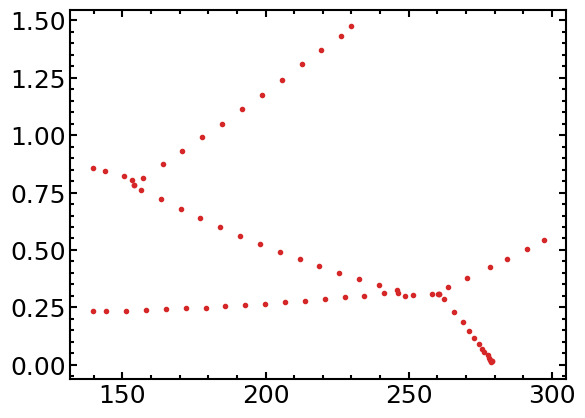

In [698]:
marker = '.'
plt.scatter(Liq_Ih[:,0], Liq_Ih[:,1]*1e-4, c=c, ls='-', marker=marker)
plt.scatter(Liq_V[:,0], Liq_V[:,1]*1e-4, c=c, ls='-', marker=marker)
plt.scatter(Ih_II[:,0], Ih_II[:,1]*1e-4, c=c, ls='-', marker=marker)
plt.scatter(Ih_V[:,0], Ih_V[:,1]*1e-4, c=c, ls='-', marker=marker)
plt.scatter(II_V[:,0], II_V[:,1]*1e-4, c=c, ls='-', marker=marker)
plt.scatter(II_VI[:,0], II_VI[:,1]*1e-4, c=c, ls='-', marker=marker)
plt.scatter(V_VI[:,0], V_VI[:,1]*1e-4, c=c, ls='-', label='revPBE0-D3', marker=marker)

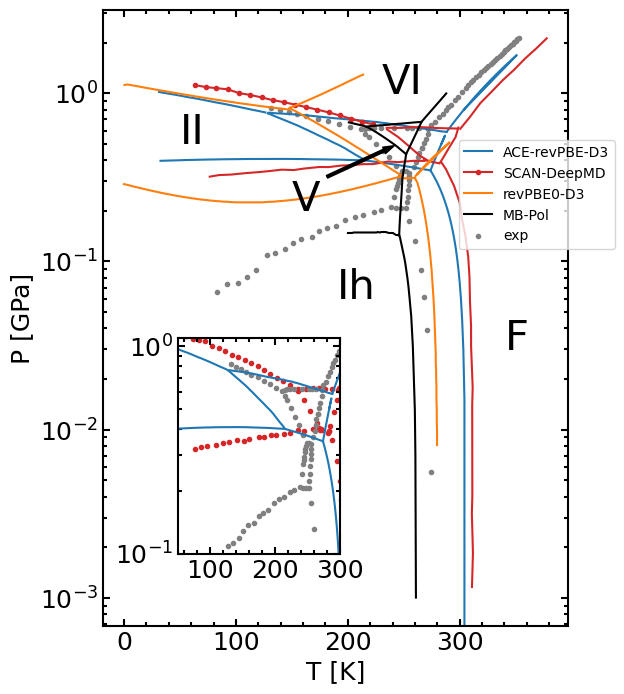

In [408]:
fig, ax= plt.subplots(figsize=(6,8))

ace_c = 'C0'
ace_marker = ''
ax.plot(ih_liq[0,:][ih_liq[0,:]>=T_triple_ih_liq],
            ih_liq[1,:][ih_liq[0,:]>=T_triple_ih_liq], marker=ace_marker, c=ace_c)
ax.plot(v_vi[0,:][v_vi[0,:]>=T_triple_ii_vi],
            v_vi[1,:][v_vi[0,:]>=T_triple_ii_vi], marker=ace_marker, c=ace_c)
ax.plot(vi_liq[0,:][vi_liq[0,:]>=T_triple_v_vi],
            vi_liq[1,:][vi_liq[0,:]>=T_triple_v_vi], marker=ace_marker, c=ace_c)
ax.plot(ih_v[0,:][ih_v[0,:]>=T_triple_ii_v],
            ih_v[1,:][ih_v[0,:]>=T_triple_ii_v], marker=ace_marker, c=ace_c)
ax.plot(ii_v[0,:][ii_v[0,:]>=T_triple_ii_vi],
            ii_v[1,:][ii_v[0,:]>=T_triple_ii_vi], marker=ace_marker, c=ace_c)
ax.plot(ii_ih[0,:][ii_ih[0,:]<=T_triple_ii_v],
            ii_ih[1,:][ii_ih[0,:]<=T_triple_ii_v], marker=ace_marker, c=ace_c)


ax.plot(v_liq[0,:][(v_liq[0,:]<=T_triple_v_vi) & (v_liq[0,:]>=T_triple_ih_liq )],
            v_liq[1,:][(v_liq[0,:]<=T_triple_v_vi) & (v_liq[0,:]>=T_triple_ih_liq )],
         marker=ace_marker, c=ace_c)
ax.plot(ii_ih[0,:][(ii_ih[0,:]<=T_triple_v_vi) & (ii_ih[0,:]>=T_triple_ih_liq )],
            ii_ih[1,:][(ii_ih[0,:]<=T_triple_v_vi) & (ii_ih[0,:]>=T_triple_ih_liq )], 
         marker=ace_marker, c=ace_c)
ax.plot(ii_v[0,:][(ii_v[0,:]<=T_triple_v_vi) & (ii_v[0,:]>=T_triple_ih_liq )],
            ii_v[1,:][(ii_v[0,:]<=T_triple_v_vi) & (ii_v[0,:]>=T_triple_ih_liq )],
         marker=ace_marker, c=ace_c, label='ACE-revPBE-D3')

ax.plot(ii_vi[0,:],ii_vi[1,:], marker=ace_marker, c=ace_c)


scan_c = 'C3'
ax.plot(pd_scan_v_vi['T'], pd_scan_v_vi['P'], c=scan_c, marker='', ls='-')
ax.plot(pd_scan_liq_ih['T'], pd_scan_liq_ih['P'], c=scan_c, marker='', ls='-')
ax.plot(pd_scan_liq_v['T'], pd_scan_liq_v['P'], c=scan_c, marker='', ls='-')
ax.plot(pd_scan_liq_vi['T'], pd_scan_liq_vi['P'], c=scan_c, marker='', ls='-')
ax.plot(pd_scan_ih_ii['T'], pd_scan_ih_ii['P'], c=scan_c,  marker='', ls='-')
ax.plot(pd_scan_ih_v['T'], pd_scan_ih_v['P'], c=scan_c,  marker='', ls='-')
ax.plot(pd_scan_ii_v['T'], pd_scan_ii_v['P'], c=scan_c, marker='', ls='-')
ax.plot(pd_scan_ii_vi['T'], pd_scan_ii_vi['P'], c=scan_c, label='SCAN-DeepMD', marker='.', ls='-')

ax.plot(Liq_Ih[:,0], Liq_Ih[:,1]*1e-4, c='C1', ls='-', marker='')
ax.plot(Liq_V[:,0], Liq_V[:,1]*1e-4, c='C1', ls='-', marker='')
ax.plot(Ih_II[:,0], Ih_II[:,1]*1e-4, c='C1', ls='-', marker='')
ax.plot(Ih_V[:,0], Ih_V[:,1]*1e-4, c='C1', ls='-', marker='')
ax.plot(II_V[:,0], II_V[:,1]*1e-4, c='C1', ls='-', marker='')
ax.plot(II_VI[:,0], II_VI[:,1]*1e-4, c='C1', ls='-', marker='')
ax.plot(V_VI[:,0], V_VI[:,1]*1e-4, c='C1', ls='-', label='revPBE0-D3', marker='')

# plt.scatter(T_triple_ih_liq, P_triple_ih_liq, marker='.', color=ace_c, zorder=4)
# plt.scatter(T_triple_v_vi, P_triple_v_vi, marker='.', color=ace_c, zorder=4)
# plt.scatter(T_triple_ii_v, P_triple_ii_v, marker='.', color=ace_c, zorder=4)
# plt.scatter(T_triple_ii_vi, P_triple_ii_vi, marker='.', color=ace_c, zorder=4, label='ACE-Triples')


ax.plot(pd_mp_bol_ih_liq['T'], pd_mp_bol_ih_liq['P'], c='k', marker='', ls='-')
ax.plot(pd_mp_bol_ih_ii['T'], pd_mp_bol_ih_ii['P'], c='k', marker='', ls='-')
ax.plot(pd_mp_bol_iii_liq['T'], pd_mp_bol_iii_liq['P'], c='k', marker='', ls='-')
ax.plot(pd_mp_bol_v_liq['T'], pd_mp_bol_v_liq['P'], c='k', marker='', ls='-')
ax.plot(pd_mp_bol_ii_v['T'], pd_mp_bol_ii_v['P'], c='k', marker='', ls='-')
ax.plot(pd_mp_bol_v_vi['T'], pd_mp_bol_v_vi['P'], c='k', marker='', ls='-', label='MB-Pol')


ax.scatter(exp_pd['P'], exp_pd['T']*1e-4, c='gray', label='exp', marker='.')

ax.set_xlabel('T [K]')
ax.set_ylabel('P [GPa]')

ax.set_yscale('log')

# Create an inset axis
ax_inset = plt.axes([0.25, 0.2, 0.27, 0.27])
ax_inset.set_xscale('linear')
ax_inset.set_yscale('log')
ax_inset.set_xlim(50, 300)
ax_inset.set_ylim(0.1, 1.1)

# Plot the data in the inset axis

ax_inset.plot(ih_liq[0,:][ih_liq[0,:]>=T_triple_ih_liq],
            ih_liq[1,:][ih_liq[0,:]>=T_triple_ih_liq], marker=ace_marker, c=ace_c)
ax_inset.plot(v_vi[0,:][v_vi[0,:]>=T_triple_ii_vi],
            v_vi[1,:][v_vi[0,:]>=T_triple_ii_vi], marker=ace_marker, c=ace_c)
ax_inset.plot(vi_liq[0,:][vi_liq[0,:]>=T_triple_v_vi],
            vi_liq[1,:][vi_liq[0,:]>=T_triple_v_vi], marker=ace_marker, c=ace_c)
ax_inset.plot(ih_v[0,:][ih_v[0,:]>=T_triple_ii_v],
            ih_v[1,:][ih_v[0,:]>=T_triple_ii_v], marker=ace_marker, c=ace_c)
ax_inset.plot(ii_v[0,:][ii_v[0,:]>=T_triple_ii_vi],
            ii_v[1,:][ii_v[0,:]>=T_triple_ii_vi], marker=ace_marker, c=ace_c)
ax_inset.plot(ii_ih[0,:][ii_ih[0,:]<=T_triple_ii_v],
            ii_ih[1,:][ii_ih[0,:]<=T_triple_ii_v], marker=ace_marker, c=ace_c)

ax_inset.plot(v_liq[0,:][(v_liq[0,:]<=T_triple_v_vi) & (v_liq[0,:]>=T_triple_ih_liq )],
            v_liq[1,:][(v_liq[0,:]<=T_triple_v_vi) & (v_liq[0,:]>=T_triple_ih_liq )],
              marker=ace_marker, c=ace_c)
ax_inset.plot(ii_ih[0,:][(ii_ih[0,:]<=T_triple_v_vi) & (ii_ih[0,:]>=T_triple_ih_liq )],
            ii_ih[1,:][(ii_ih[0,:]<=T_triple_v_vi) & (ii_ih[0,:]>=T_triple_ih_liq )], 
              marker=ace_marker, c=ace_c)
ax_inset.plot(ii_v[0,:][(ii_v[0,:]<=T_triple_v_vi) & (ii_v[0,:]>=T_triple_ih_liq )],
            ii_v[1,:][(ii_v[0,:]<=T_triple_v_vi) & (ii_v[0,:]>=T_triple_ih_liq )],
         marker=ace_marker, c=ace_c)
ax_inset.plot(ii_vi[0,:],ii_vi[1,:], marker=ace_marker, c=ace_c)


ax_inset.scatter(pd_scan_liq_ih['T'], pd_scan_liq_ih['P'], c=scan_c, marker='.', ls='-')
ax_inset.scatter(pd_scan_liq_v['T'], pd_scan_liq_v['P'], c=scan_c, marker='.', ls='-')
ax_inset.scatter(pd_scan_liq_vi['T'], pd_scan_liq_vi['P'], c=scan_c, marker='.', ls='-')
ax_inset.scatter(pd_scan_ih_ii['T'], pd_scan_ih_ii['P'], c=scan_c,  marker='.', ls='-')
ax_inset.scatter(pd_scan_ih_v['T'], pd_scan_ih_v['P'], c=scan_c,  marker='.', ls='-')
ax_inset.scatter(pd_scan_v_vi['T'], pd_scan_v_vi['P'], c=scan_c, marker='.', ls='-')
ax_inset.scatter(pd_scan_ii_v['T'], pd_scan_ii_v['P'], c=scan_c, marker='.', ls='-')
ax_inset.scatter(pd_scan_ii_vi['T'], pd_scan_ii_vi['P'], c=scan_c, label='SCAN-DeepMD', marker='.', ls='-')

ax_inset.scatter(exp_pd['P'], exp_pd['T']*1e-4, c='gray', label='exp', marker='.')

ax.text(340,0.03, 'F', fontsize=30)
ax.text(190,0.06, 'Ih', fontsize=30)
ax.text(230,1, 'VI', fontsize=30)
ax.text(50,0.5, 'II', fontsize=30)
ax.annotate('V', xy=(245, 0.5), xytext=(150,.2), fontsize=30,
    arrowprops=dict(facecolor='k', shrink=0.05, width=2, headwidth=5, headlength=8))

# ax.indicate_inset_zoom(ax_inset, edgecolor="black")

ax.legend(frameon=1, loc='upper left', fontsize=10, ncol=1, bbox_to_anchor=(.75,0.8))
plt.show()
#fig.savefig('../figures/pd.png', bbox_inches = 'tight', dpi=300);

In [338]:
args_ace = np.argsort(vi_liq[0,:])
vi_liq[0,:] = vi_liq[0,:][args_ace]
vi_liq[1,:] = vi_liq[1,:][args_ace]

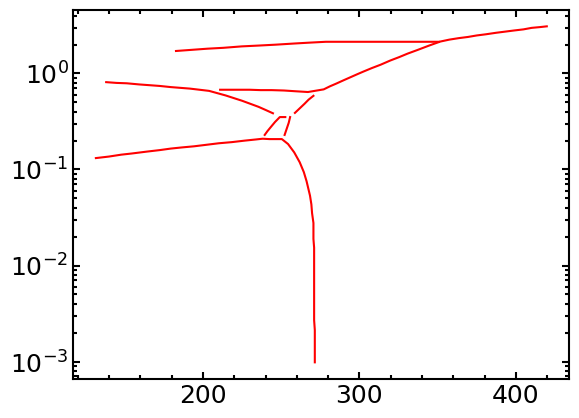

In [683]:
#plt.scatter(exp_pd['T'], exp_pd['P'], c='gray', label='exp', marker='.')
plt.plot(exp_pd['T'][:46], exp_pd['P'][:46], c='r', label='exp', marker='')
plt.plot(exp_pd['T'][46:50], exp_pd['P'][46:50], c='r', label='exp', marker='')
plt.plot(exp_pd['T'][50:56], exp_pd['P'][50:56], c='r', label='exp', marker='')
plt.plot(exp_pd['T'][56:61], exp_pd['P'][56:61], c='r', label='exp', marker='')
plt.plot(exp_pd['T'][62:81], exp_pd['P'][62:81], c='r', label='exp', marker='')
plt.plot(exp_pd['T'][81:117], exp_pd['P'][81:117], c='r', label='exp', marker='')
plt.plot(exp_pd['T'][118:], exp_pd['P'][118:], c='r', label='exp', marker='')
plt.yscale('log')

In [917]:
pd_scan_liq_ih = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/ref_data/liq_ih_scan.dat',
                             names=['T','P'], sep=',')
pd_scan_liq_v = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/ref_data/liq_v_scan.dat',
                             names=['T','P'], sep=',')
pd_scan_liq_vi = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/ref_data/liq_vi_scan.dat',
                             names=['T','P'], sep=',')
pd_scan_ih_v = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/ref_data/ih_v_scan.dat',
                             names=['T','P'], sep=',')
pd_scan_ih_ii = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/ref_data/ih_ii_scan.dat',
                             names=['T','P'], sep=',')
pd_scan_ii_v = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/ref_data/ii_v_scan.dat',
                             names=['T','P'], sep=',')
pd_scan_ii_vi = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/ref_data/ii_vi_scan.dat',
                             names=['T','P'], sep=',')
pd_scan_v_vi = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/ref_data/v_vi_scan.dat',
                             names=['T','P'], sep=',')
pd_scan_vi_vii = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/ref_data/vi_vii_scan.dat',
                             names=['T','P'], sep=',')

In [835]:
Liq_Ih[args,0], Liq_Ih[args,1]*1e-4

(array([266.02334814, 278.94473234, 279.07131977, 279.08584981,
        278.31278589, 278.17318197, 277.564379  , 276.48183634,
        275.71124913, 274.46711486, 272.81830968, 271.03510953,
        268.84448657]),
 array([0.22799106, 0.01054717, 0.01456679, 0.01810545, 0.02250715,
        0.02942933, 0.04046714, 0.05467296, 0.0705314 , 0.08965873,
        0.11462774, 0.14792299, 0.18423889]))

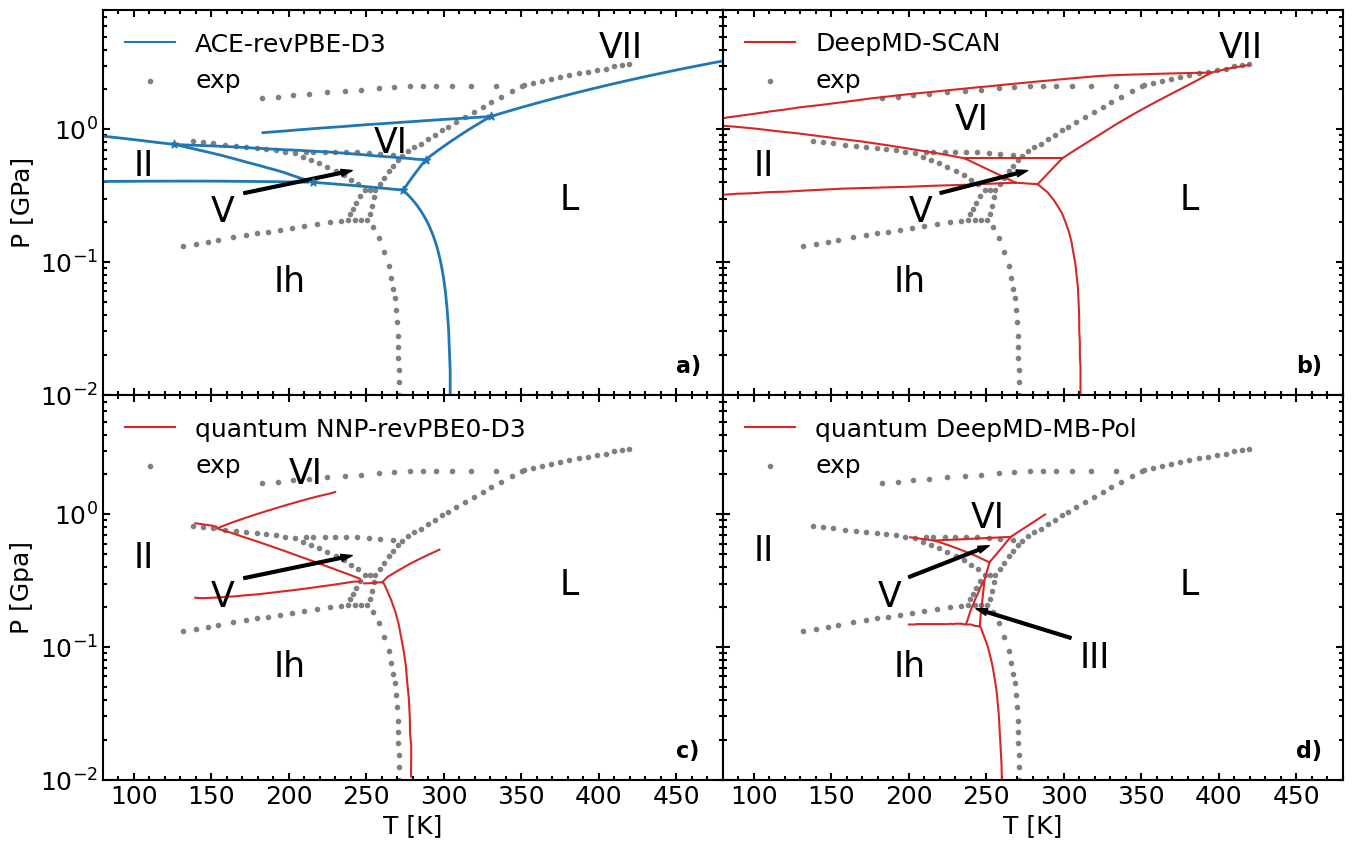

In [945]:
fig, ax= plt.subplots(figsize=(16,10), ncols=2, nrows=2, sharex=True, sharey=True)
ax = ax.flatten()
fig.subplots_adjust(wspace=0, hspace=0)

ace_c = 'C0'
ace_marker = ''
ax[0].plot(ih_liq[0,:][ih_liq[0,:]>=T_triple_ih_liq],
            ih_liq[1,:][ih_liq[0,:]>=T_triple_ih_liq], marker=ace_marker, c=ace_c, lw=2)
ax[0].plot(v_vi[0,:][v_vi[0,:]>=T_triple_ii_vi],
            v_vi[1,:][v_vi[0,:]>=T_triple_ii_vi], marker=ace_marker, c=ace_c, lw=2)
ax[0].plot(vii_liq[0,:][vii_liq[0,:]>=T_triple_vi_vii],
            vii_liq[1,:][vii_liq[0,:]>=T_triple_vi_vii], marker=ace_marker, c=ace_c, lw=2)
ax[0].plot(ih_v[0,:][ih_v[0,:]>=T_triple_ii_v],
            ih_v[1,:][ih_v[0,:]>=T_triple_ii_v], marker=ace_marker, c=ace_c, lw=2)
ax[0].plot(ii_v[0,:][ii_v[0,:]>=T_triple_ii_vi],
            ii_v[1,:][ii_v[0,:]>=T_triple_ii_vi], marker=ace_marker, c=ace_c, lw=2)
ax[0].plot(ii_ih[0,:][ii_ih[0,:]<=T_triple_ii_v],
            ii_ih[1,:][ii_ih[0,:]<=T_triple_ii_v], marker=ace_marker, c=ace_c, lw=2)
ax[0].plot(vi_vii[0,:], vi_vii[1,:], marker=ace_marker, c=ace_c, lw=2)


ax[0].plot(v_liq[0,:][(v_liq[0,:]<=T_triple_v_vi) & (v_liq[0,:]>=T_triple_ih_liq )],
            v_liq[1,:][(v_liq[0,:]<=T_triple_v_vi) & (v_liq[0,:]>=T_triple_ih_liq )],
         marker=ace_marker, c=ace_c, lw=2)
ax[0].plot(vi_liq[0,:][(vi_liq[0,:]>=T_triple_v_vi) & (vi_liq[0,:]<=T_triple_vi_vii )],
            vi_liq[1,:][(vi_liq[0,:]>=T_triple_v_vi) & (vi_liq[0,:]<=T_triple_vi_vii )],
         marker=ace_marker, c=ace_c, lw=2)
ax[0].plot(ii_ih[0,:][(ii_ih[0,:]<=T_triple_v_vi) & (ii_ih[0,:]>=T_triple_ih_liq )],
            ii_ih[1,:][(ii_ih[0,:]<=T_triple_v_vi) & (ii_ih[0,:]>=T_triple_ih_liq )], 
         marker=ace_marker, c=ace_c, lw=2)
ax[0].plot(ii_v[0,:][(ii_v[0,:]<=T_triple_v_vi) & (ii_v[0,:]>=T_triple_ih_liq )],
            ii_v[1,:][(ii_v[0,:]<=T_triple_v_vi) & (ii_v[0,:]>=T_triple_ih_liq )],
         marker=ace_marker, c=ace_c, label='ACE-revPBE-D3')
ax[0].plot(ii_vi[0,:],ii_vi[1,:], marker=ace_marker, c=ace_c, lw=2)

ax[0].scatter(T_triple_ih_liq, P_triple_ih_liq, marker='*', color=ace_c, zorder=4)
ax[0].scatter(T_triple_v_vi, P_triple_v_vi, marker='*', color=ace_c, zorder=4)
ax[0].scatter(T_triple_ii_v, P_triple_ii_v, marker='*', color=ace_c, zorder=4)
ax[0].scatter(T_triple_ii_vi, P_triple_ii_vi, marker='*', color=ace_c, zorder=4)
ax[0].scatter(T_triple_vi_vii, P_triple_vi_vii, marker='*', color=ace_c, zorder=4)

ax[0].text(375,0.25, 'L', fontsize=25)
ax[0].text(190,0.06, 'Ih', fontsize=25)
ax[0].text(100,0.45, 'II', fontsize=25)
ax[0].text(255,.67, 'VI', fontsize=25)
ax[0].text(400,3.5, 'VII', fontsize=25)


ax[0].annotate('V', xy=(245, 0.5), xytext=(150,.2), fontsize=25,
    arrowprops=dict(facecolor='k', shrink=0.05, width=2, headwidth=5, headlength=8))


# ax[0].scatter(exp_pd['P'], exp_pd['T']*1e-4, c='gray', label='exp', marker='.')
ax[0].scatter(exp_pd['T'], exp_pd['P'], c='gray', label='exp', marker='.')
########################################################################################################


c = 'C3'
marker=''
ax[1].plot(pd_scan_liq_ih['T'], pd_scan_liq_ih['P'], c=c, marker=marker, ls='-')
ax[1].plot(pd_scan_liq_v['T'], pd_scan_liq_v['P'], c=c, marker=marker, ls='-')
ax[1].plot(pd_scan_liq_vi['T'], pd_scan_liq_vi['P'], c=c, marker=marker, ls='-')
ax[1].plot(pd_scan_ih_ii['T'], pd_scan_ih_ii['P'], c=c,  marker=marker, ls='-')
ax[1].plot(pd_scan_ih_v['T'], pd_scan_ih_v['P'], c=c,  marker=marker, ls='-')
ax[1].plot(pd_scan_ii_v['T'], pd_scan_ii_v['P'], c=c, marker=marker, ls='-')
ax[1].plot(pd_scan_ii_vi['T'], pd_scan_ii_vi['P'], c=c, marker=marker, ls='-')
ax[1].plot(pd_scan_v_vi['T'], pd_scan_v_vi['P'], c=c, marker=marker, ls='-')
ax[1].plot(pd_scan_vi_vii['T'], pd_scan_vi_vii['P'], c=c, marker=marker, ls='-', label='DeepMD-SCAN')

# ax[1].scatter(exp_pd['P'], exp_pd['T']*1e-4, c='gray', label='exp', marker='.')
ax[1].scatter(exp_pd['T'], exp_pd['P'], c='gray', label='exp', marker='.')


ax[1].text(375,0.25, 'L', fontsize=25)
ax[1].text(190,0.06, 'Ih', fontsize=25)
ax[1].text(230,1., 'VI', fontsize=25)
ax[1].text(400,3.5, 'VII', fontsize=25)
ax[1].text(100,0.45, 'II', fontsize=25)
ax[1].annotate('V', xy=(280, 0.5), xytext=(200,.2), fontsize=25,
    arrowprops=dict(facecolor='k', shrink=0.05, width=2, headwidth=5, headlength=8))
########################################################################################################
args = np.argsort(Liq_Ih[:,1])
ax[2].plot(Liq_Ih[args,0], Liq_Ih[args,1]*1e-4, c=c, ls='-', marker=marker)
args = np.argsort(Liq_V[:,0])
ax[2].plot(Liq_V[:,0][args], Liq_V[:,1][args]*1e-4, c=c, ls='-', marker=marker)
args = np.argsort(Ih_II[:,0])
ax[2].plot(Ih_II[:,0][args], Ih_II[:,1][args]*1e-4, c=c, ls='-', marker=marker)
args = np.argsort(Ih_V[:,0])
ax[2].plot(Ih_V[:,0][args], Ih_V[:,1][args]*1e-4, c=c, ls='-', marker=marker)
args = np.argsort(II_V[:,0])
ax[2].plot(II_V[:,0][args], II_V[:,1][args]*1e-4, c=c, ls='-', marker=marker)
args = np.argsort(II_VI[:,0])
ax[2].plot(II_VI[:,0][args], II_VI[:,1][args]*1e-4, c=c, ls='-', marker=marker)
args = np.argsort(V_VI[:,0])
ax[2].plot(V_VI[:,0][args], V_VI[:,1][args]*1e-4, c=c, ls='-', label='quantum NNP-revPBE0-D3', marker=marker)

# ax[2].scatter(exp_pd['P'], exp_pd['T']*1e-4, c='gray', label='exp', marker='.')
ax[2].scatter(exp_pd['T'], exp_pd['P'], c='gray', label='exp', marker='.')

ax[2].text(375,0.25, 'L', fontsize=25)
ax[2].text(190,0.06, 'Ih', fontsize=25)
ax[2].text(200,1.7, 'VI', fontsize=25)
# ax[2].text(400,3.5, 'VII', fontsize=25)
ax[2].text(100,0.4, 'II', fontsize=25)
ax[2].annotate('V', xy=(245, 0.5), xytext=(150,.2), fontsize=25,
    arrowprops=dict(facecolor='k', shrink=0.05, width=2, headwidth=5, headlength=8))
########################################################################################################
ax[3].plot(pd_mp_bol_ih_liq['T'], pd_mp_bol_ih_liq['P'], c=c, marker=marker, ls='-')
ax[3].plot(pd_mp_bol_ih_ii['T'], pd_mp_bol_ih_ii['P'], c=c, marker=marker, ls='-')
ax[3].plot(pd_mp_bol_iii_liq['T'], pd_mp_bol_iii_liq['P'], c=c, marker=marker, ls='-')
ax[3].plot(pd_mp_bol_v_liq['T'], pd_mp_bol_v_liq['P'], c=c, marker=marker, ls='-')
ax[3].plot(pd_mp_bol_ii_iii['T'], pd_mp_bol_ii_iii['P'], c=c, marker=marker, ls='-')
ax[3].plot(pd_mp_bol_ii_v['T'], pd_mp_bol_ii_v['P'], c=c, marker=marker, ls='-')
ax[3].plot(pd_mp_bol_v_vi['T'], pd_mp_bol_v_vi['P'], c=c, marker=marker, ls='-', label='quantum DeepMD-MB-Pol')

# ax[3].scatter(exp_pd['P'], exp_pd['T']*1e-4, c='gray', label='exp', marker='.')
ax[3].scatter(exp_pd['T'], exp_pd['P'], c='gray', label='exp', marker='.')

ax[3].text(375,0.25, 'L', fontsize=25)
ax[3].text(190,0.06, 'Ih', fontsize=25)
ax[3].text(100,0.45, 'II', fontsize=25)
ax[3].text(240,0.8, 'VI', fontsize=25)

ax[3].annotate('V', xy=(255, 0.6), xytext=(180,.2), fontsize=25,
    arrowprops=dict(facecolor='k', shrink=0.05, width=2, headwidth=5, headlength=8))
ax[3].annotate('III', xy=(240, 0.2), xytext=(310,.07), fontsize=25,
    arrowprops=dict(facecolor='k', shrink=0.05, width=2, headwidth=5, headlength=8))
########################################################################################################


ax[0].legend(frameon=0, fontsize=18, loc=2)
ax[1].legend(frameon=0, fontsize=18, loc=2)
ax[2].legend(frameon=0, fontsize=18, loc=2)
ax[3].legend(frameon=0, fontsize=18, loc=2)


ax[2].set_xlabel('T [K]')
ax[3].set_xlabel('T [K]')

ax[0].set_ylabel('P [GPa]')
ax[2].set_ylabel('P [Gpa]')


plt.yscale('log')
plt.ylim(0.01,8)
plt.xlim(80,480)

label_kwargs = dict(fontsize=16, fontweight='bold', va='top')
ax[0].text(450,0.02, 'a)',  **label_kwargs)
ax[1].text(450,0.02, 'b)',  **label_kwargs)
ax[2].text(450,0.02, 'c)',  **label_kwargs)
ax[3].text(450,0.02, 'd)',  **label_kwargs)

# ax_rmse_E.text(0.1, 0.95, 'a)', transform=ax_rmse_E.transAxes, ha='left',  **label_kwargs)
# ax_rmse_F.text(0.1, 0.95, 'b)', transform=ax_rmse_F.transAxes, ha='left',  **label_kwargs)
# ax_E.text(0.95, 0.1, 'c)', transform=ax_E.transAxes, ha='right', **label_kwargs)
# ax_F.text(0.95, 0.1, 'd)', transform=ax_F.transAxes, ha='right', **label_kwargs)

fig.savefig('../figures/pd.png', bbox_inches = 'tight', dpi=300);